# Cardiac GWAS and eQTL manuscript
- V02: 05/14/2021: first comments from Kelly, explain more in Figure 1, divide figure 1 into 2 (GWAS and finemap)
- V01: 04/28/2021

In [2]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [3]:
manuscript_version = "V01"
outfolder          = paste("manuscript", manuscript_version, sep = "/")
dir.create(outfolder                              , showWarnings = FALSE)
dir.create(paste(outfolder, "figshare", sep = "/"), showWarnings = FALSE)


In [4]:
suppressPackageStartupMessages(library(stringr   ))
suppressPackageStartupMessages(library(colorspace))
suppressPackageStartupMessages(library(kohonen   ))
suppressPackageStartupMessages(library(tempR     ))


# Part 1: analyze cardiac GWAS

In [5]:
suppressPackageStartupMessages(library(kohonen))


In [6]:
manifest       = add_rownames(fread  ("pipeline/1.1.sumstats/manifest.txt"                             , sep = "\t", header = TRUE, data.table = FALSE))
loci           = add_rownames(fread  ("pipeline/1.2.genomewide_significant_loci/loci.txt"              , sep = "\t", header = TRUE, data.table = FALSE))
loci2study     = add_rownames(fread  ("pipeline/1.2.genomewide_significant_loci/loci2study.txt"        , sep = "\t", header = TRUE, data.table = FALSE))
locus2coloc    =              fread  ("pipeline/5.4.analyze_coloc_qtl_som_maps/signal2coloc.txt"       , sep = "\t", header = TRUE, data.table = FALSE)
fm99           =              fread  ("pipeline/5.4.analyze_coloc_qtl_som_maps/finemapped_99.txt"      , sep = "\t", header = TRUE, data.table = FALSE)
cs_annot       =              fread  ("pipeline/6.2.footprints_finemap/credible_sets_50_annotated.txt" , sep = "\t", header = TRUE, data.table = FALSE)
cs2motif       =              fread  ("pipeline/6.2.footprints_finemap/cs2motif_by_variant.txt"        , sep = "\t", header = TRUE, data.table = FALSE)
test_overlap   =              fread  ("pipeline/6.2.footprints_finemap/test_overlap.txt"               , sep = "\t", header = TRUE, data.table = FALSE)
coloc_eqtls    =              fread  ("pipeline/5.5.meta_analysis/coloc_eqtls.txt"                     , sep = "\t", header = TRUE, data.table = FALSE)
moloc_df       =              fread  ("pipeline/2.2.moloc/moloc.txt"                                   , sep = "\t", header = TRUE, data.table = FALSE)
exons          =              fread  ("/frazer01/reference/private/Gencode.v34lift37/exon_info.txt"    , sep = "\t", header = TRUE, data.table = FALSE)
moloc_list     =              readRDS("pipeline/2.2.moloc/moloc_list.rds")
moloc_map_list =              readRDS("pipeline/2.2.moloc/moloc_map_list.rds")
moloc_df       = moloc_df  [ moloc_df$n_signif > 0,]
loci           = loci      [ moloc_df$locus,]
loci2study     = loci2study[ moloc_df$locus,]


In [7]:
str(locus2coloc)

'data.frame':	3426 obs. of  20 variables:
 $ chrom       : int  0 0 0 0 0 0 0 0 0 0 ...
 $ pos         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ som         : int  376 376 376 348 376 376 376 33 376 357 ...
 $ id          : chr  "17_68319330_68611145.1" "18_55765613_56357531.1" "5_130403286_131933599.2" "13_25708286_26013798.1" ...
 $ locus       : chr  "17_68319330_68611145" "18_55765613_56357531" "5_130403286_131933599" "13_25708286_26013798" ...
 $ cluster     : int  7 7 7 17 7 7 7 28 7 7 ...
 $ class       : chr  "V376" "V376" "V376" "V348" ...
 $ traits      : chr  "biomarkers-30760-both_sexes-irnt; biomarkers-30870-both_sexes-irnt" "biomarkers-30760-both_sexes-irnt; biomarkers-30870-both_sexes-irnt" "biomarkers-30760-both_sexes-irnt; biomarkers-30870-both_sexes-irnt" "biomarkers-30870-both_sexes-irnt; continuous-MAP-both_sexes-combined_medadj_irnt; continuous-SBP-both_sexes-com"| __truncated__ ...
 $ traits_n    : int  2 2 2 3 2 2 2 2 2 3 ...
 $ eqtls       : chr  "" "" "" "" ...
 $ eqtl

In [6]:
trait2loci        = manifest[, c("id", "name", "trait_type")]
trait2loci$n_loci = as.numeric(colSums(loci2study[, trait2loci$id]))

In [7]:
populations = c('meta','AFR','AMR','CSA','EAS','EUR','MID')

In [8]:
exp_data = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")
qtl_data = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )


In [9]:
meta_list        = lapply(locus2coloc$id, function(id){readRDS(paste0("pipeline/5.5.meta_analysis/coloc_data/", id, ".rds"))})
names(meta_list) = locus2coloc$id

In [10]:
coordinates = exp_data[["coordinates"]]
gene_info   = coordinates[ coordinates$phenotype == "rna",]


In [11]:
cs2bin = data.frame(bin  = 1:7, 
                    from = c(0, 1,  5, 10, 20,  50,   100), 
                    to   = c(1, 5, 10, 20, 50, 100, 10000))
cs2bin$bin_name = paste(cs2bin$from + 1, cs2bin$to, sep = "-")
cs2bin[1,"bin_name"] = "1"
cs2bin[7,"bin_name"] = "101+"

signal2bin          = locus2coloc
signal2bin$bin_name = ""

for(bin in cs2bin$bin)
{
    from = cs2bin[bin, "from"    ]
    to   = cs2bin[bin, "to"      ]
    name = cs2bin[bin, "bin_name"]

    if(nrow(signal2bin[signal2bin$credible_set > from & signal2bin$credible_set <= to, ]) > 0){signal2bin[signal2bin$credible_set > from & signal2bin$credible_set <= to, "bin_name"] = name}
}
cs2bin = rbind(cs2bin, data.frame(bin = 8, from = -1, to = -1, bin_name = "Not resolved"))

signal2bin[ signal2bin$finemapped == FALSE, "bin_name"] = "Not resolved"
signal2bin = merge(signal2bin, cs2bin, by = "bin_name")


In [12]:
map      = moloc_map_list[["som"]][["map"     ]]
g        = moloc_map_list[["som"]][["som_grid"]]
clusters = moloc_map_list[["som"]][["clusters"]]


In [13]:
colordata_tissue = exp_data[["color"]][["by_tissue"]]
colordata_organ  = exp_data[["color"]][["by_organ" ]]
colordata_cell   = exp_data[["color"]][["by_cell"  ]]

colordata_tissue = colordata_tissue[colordata_tissue$body_site != "ipsc_cvpc",]
colordata_stage  = colordata_organ [c("ipsc_cvpc", "adult"),]
colordata_organ  = colordata_organ [c("arteria"  , "heart"),]

colordata_stage $order = 1:2
colordata_organ $order = 1:2
colordata_tissue$order = 1:nrow(colordata_tissue)

rownames(colordata_cell) = colordata_cell$cell_type
colordata_cell           = colordata_cell[,c("cell_type", "name", "color", "order")] 

mycols                    = c("body_site", "name", "color", "order")
colnames(colordata_stage ) = mycols
colnames(colordata_organ ) = mycols
colnames(colordata_tissue) = mycols
colnames(colordata_cell  ) = mycols

colordata_stage $type = "stage"
colordata_organ $type = "organ"
colordata_tissue$type = "tissue"
colordata_cell  $type = "cell"

colordata = list(by_stage = colordata_stage, by_organ = colordata_organ, by_tissue = colordata_tissue, by_cell = colordata_cell)

## Correlation matrix between traits (based on how many signals overlap)

In [14]:
jaccard_score = function(trait1, trait2, df)
{
    indata = rowSums(df[,c(trait1, trait2)])
    score  = length(indata[indata == 2]) / length(indata[indata >0])
    
    return(score)
}

cordata_jaccard       = matrix(0, nrow = ncol(map$data[[1]]), ncol = ncol(map$data[[1]]), dimnames = list(colnames(map$data[[1]]), colnames(map$data[[1]])))
diag(cordata_jaccard) = 1
mycombs               = combn(x = colnames(cordata_jaccard), m = 2)

for(ii in 1:ncol(mycombs))
{
    trait1 = mycombs[1, ii]
    trait2 = mycombs[2, ii]
    score  = jaccard_score(trait1, trait2, map$data[[1]])
    
    cordata_jaccard[trait1, trait2] = score
    cordata_jaccard[trait2, trait1] = score
}


In [15]:
cordata_cor = cor(map$codes[[1]])

In [16]:
cluster_cor     = hclust(as.dist(1 - (cordata_cor    )))
cluster_jaccard = hclust(as.dist(1 - (cordata_jaccard)))


corrplot 0.84 loaded



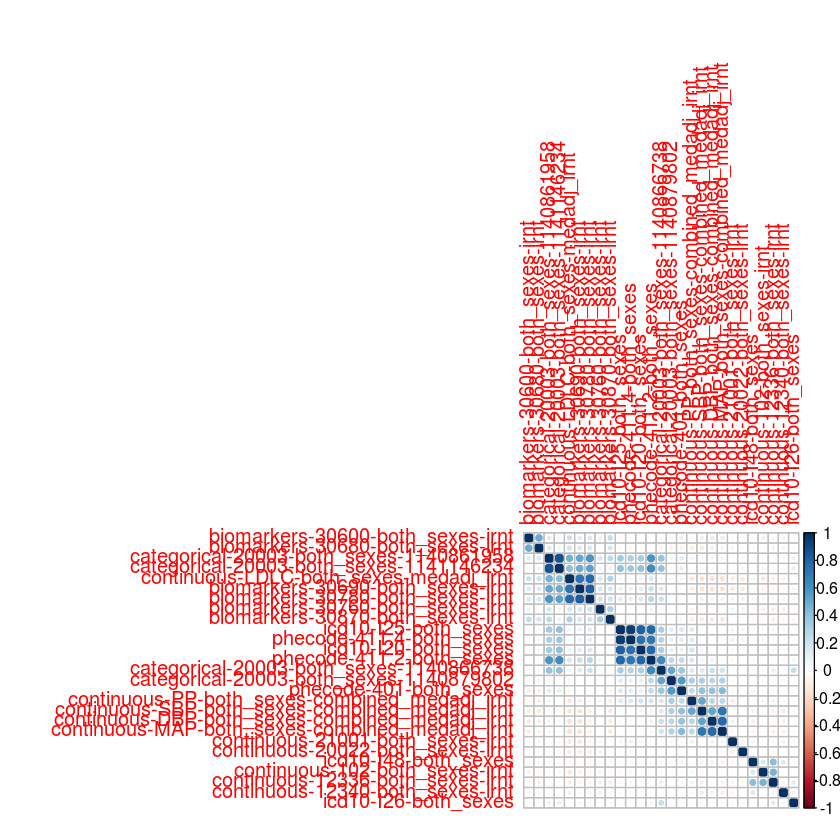

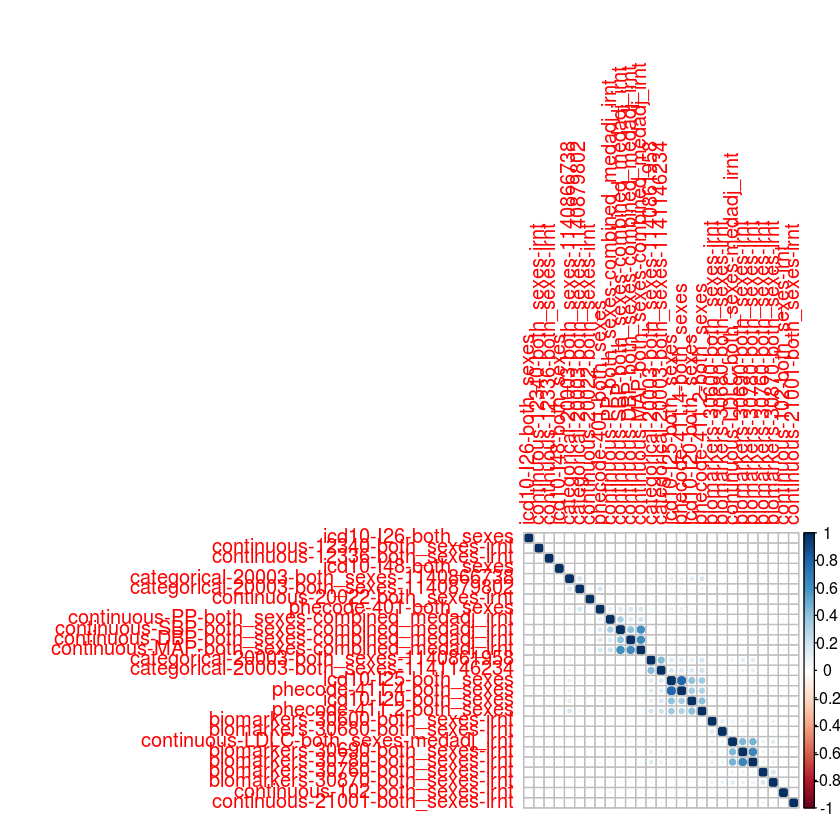

In [17]:
library(corrplot)
corrplot(cordata_cor    , order = "hclust")
corrplot(cordata_jaccard, order = "hclust")


## loci and traits
- analysis on all populations. We use only meta analysis (across populations), otherwise it would become too complicated
- some loci (n_signif == 0 in moloc_df) are associated only with specific populations, but not in meta analysis
- each signal (there may be more than one signal in a locus) is clustered using Kohonen's self organizing maps (SOM) on a 20-by-20 grid, then clustered with k-means (k = 20)
- <b>conclusion 1</b>: so many different associations likely underlie differences in intermediate phenotypes (cell type and stage): look at eQTLs in fetal and adult
- <b>conclusion 2</b>: so many loci have the same signal from multiple GWAS: can we fine map each independent signal by combining all the GWAS and eQTL signals at the same locus?


In [18]:
n_loci            = nrow(moloc_df[ moloc_df$n_signif >  0, ])
n_loci_1          = nrow(moloc_df[ moloc_df$n_signif == 1, ])
n_loci_n          = nrow(moloc_df[ moloc_df$n_signif >  1, ])
signal_locus_mean = mean(moloc_df[ moloc_df$n_signif >  0, "n_signif"])
signal_locus_sd   = sd  (moloc_df[ moloc_df$n_signif >  0, "n_signif"])
signal_locus_max  = max (moloc_df[ moloc_df$n_signif >  0, "n_signif"])

locus_size_mean = signif(mean(loci$size)* 1e-3, digits = 3)
locus_size_sd   = signif(sd  (loci$size)* 1e-3, digits = 3)

message(paste(paste("Significant loci", n_loci  , sep = " = "),
              paste("Locus size"      , paste(locus_size_mean, "+/-", locus_size_sd, "kb"), sep = " = "),
              
              "",
              "Significant traits per locus",
              paste(paste("Loci with one trait"      , n_loci_1, sep = " = "), " (", signif(n_loci_1 / n_loci * 100, digits = 3), "%)", sep = ""),
              paste(paste("Loci with multiple traits", n_loci_n, sep = " = "), " (", signif(n_loci_n / n_loci * 100, digits = 3), "%)", sep = ""),
              paste      (signif(signal_locus_mean, digits = 3), "+/-", signif(signal_locus_sd, digits = 3), "significant traits per locus (up to", signal_locus_max, "traits at a single locus)", sep = " "),
              sep = "\n"
             ))

n_loci_1          = nrow(moloc_df[ moloc_df$n_signals == 1, ])
n_loci_n          = nrow(moloc_df[ moloc_df$n_signals >  1, ])
signal_locus_mean = mean(moloc_df[ moloc_df$n_signals >  0, "n_signals"])
signal_locus_sd   = sd  (moloc_df[ moloc_df$n_signals >  0, "n_signals"])
signal_locus_max  = max (moloc_df[ moloc_df$n_signals >  0, "n_signals"])


message(paste("Significant GWAS signals per locus",
              paste(paste("Loci with one signal"      , n_loci_1, sep = " = "), " (", signif(n_loci_1 / n_loci * 100, digits = 3), "%)", sep = ""),
              paste(paste("Loci with multiple signals", n_loci_n, sep = " = "), " (", signif(n_loci_n / n_loci * 100, digits = 3), "%)", sep = ""),
              paste      (signif(signal_locus_mean, digits = 3), "+/-", signif(signal_locus_sd, digits = 3), "significant signals per locus (up to", signal_locus_max, "signals at a single locus)", sep = " "),
              sep = "\n"
             ))

message(paste("Loci per trait", 
              paste("Median loci per trait", median(trait2loci$n_loci), sep = " = "),
              paste("Mean loci per trait"  , paste(round(mean  (trait2loci$n_loci), digits = 1), "+/-", round(sd (trait2loci$n_loci), digits = 1)), sep = " = "),
              paste("Range"                , paste(min(trait2loci$n_loci), "for", trait2loci[which.min(trait2loci$n_loci), "name"], "to" , max(trait2loci$n_loci), "for", trait2loci[which.max(trait2loci$n_loci), "name"]), sep = " = "),
              sep = "\n"))

n_loci_1          = nrow(locus2coloc[ locus2coloc$traits_n == 1, ])
n_loci_n          = nrow(locus2coloc[ locus2coloc$traits_n >  1, ])
signal_locus_mean = mean(locus2coloc[ locus2coloc$traits_n >  0, "traits_n"])
signal_locus_sd   = sd  (locus2coloc[ locus2coloc$traits_n >  0, "traits_n"])
signal_locus_max  = max (locus2coloc[ locus2coloc$traits_n >  0, "traits_n"])


message(paste("Traits per signal", 
              paste(paste("Signals from one trait"      , n_loci_1, sep = " = "), " (", signif(n_loci_1 / (n_loci_1 + n_loci_n) * 100, digits = 3), "%)", sep = ""),
              paste(paste("Signals with multiple traits", n_loci_n, sep = " = "), " (", signif(n_loci_n / (n_loci_1 + n_loci_n) * 100, digits = 3), "%)", sep = ""),
              paste      (signif(signal_locus_mean, digits = 3), "+/-", signif(signal_locus_sd, digits = 3), "significant signals per locus (up to", signal_locus_max, "signals at a single locus)", sep = " "),
              sep = "\n"))


Significant loci = 1925
Locus size = 550 +/- 596 kb

Significant traits per locus
Loci with one trait = 798 (41.5%)
Loci with multiple traits = 1127 (58.5%)
3.26 +/- 3.08 significant traits per locus (up to 21 traits at a single locus)

Significant GWAS signals per locus
Loci with one signal = 1140 (59.2%)
Loci with multiple signals = 785 (40.8%)
1.78 +/- 1.25 significant signals per locus (up to 11 signals at a single locus)

Loci per trait
Median loci per trait = 164
Mean loci per trait = 241 +/- 240.8
Range = 9 for I26 Pulmonary embolism to 807 for Body mass index (BMI)

Traits per signal
Signals from one trait = 2210 (64.5%)
Signals with multiple traits = 1216 (35.5%)
1.81 +/- 1.53 significant signals per locus (up to 16 signals at a single locus)



In [19]:
message(paste(paste("Loci that could not be fine mapped", nrow(locus2coloc[ locus2coloc$finemapped == FALSE,]), sep = " = "),
              paste("Fine-mapped loci", paste0(nrow(locus2coloc[ locus2coloc$finemapped == TRUE,]), 
                                               " (", signif(nrow(locus2coloc[ locus2coloc$finemapped == TRUE,])/ nrow(locus2coloc) * 100, digits = 3), "%)"), sep = " = "), 
              paste0("Median number of variants in each credible set = ", 
                     median(locus2coloc[ locus2coloc$finemapped == TRUE,"credible_set"]), 
                     " +/- ", 
                     signif(sd(locus2coloc[ locus2coloc$finemapped == TRUE,"credible_set"]), digits = 3),
                     "; Range = 1-",
                     max(locus2coloc[ locus2coloc$finemapped == TRUE,"credible_set"])
                    ),
              paste0("Median size each credible set = ", 
                     median(locus2coloc[ locus2coloc$finemapped == TRUE,"cs_size"], na.rm = TRUE), 
                     " +/- ", 
                     signif(sd(locus2coloc[ locus2coloc$finemapped == TRUE,"cs_size"], na.rm = TRUE), digits = 3),
                     "; Range = 1-",
                     max(locus2coloc[ locus2coloc$finemapped == TRUE,"cs_size"], na.rm = TRUE)
                    ),
            paste("Signals with one fine-mapped variant", paste0(nrow(locus2coloc[ locus2coloc$finemapped == TRUE & locus2coloc$credible_set == 1,]), 
                                             " (", signif(nrow(locus2coloc[ locus2coloc$finemapped == TRUE  & locus2coloc$credible_set == 1,])/ nrow(locus2coloc[ locus2coloc$finemapped == TRUE,]) * 100, digits = 3), "%)"), sep = " = "), 
                            sep = "\n"))

Loci that could not be fine mapped = 133
Fine-mapped loci = 3293 (96.1%)
Median number of variants in each credible set = 18 +/- 66.5; Range = 1-1333
Median size each credible set = 59382 +/- 390000; Range = 1-7681364
Signals with one fine-mapped variant = 295 (8.96%)



## Annotate fine-mapped variants based on genes
- https://adairama.wordpress.com/2013/02/15/functionally-annotate-snps-and-indels-in-bioconductor/

In [20]:
table(fm99[,c("consequence", "consequence_category")])


                                    consequence_category
consequence                          missense non_coding synonymous
  3_prime_UTR_variant                       0         11          0
  5_prime_UTR_variant                       0          4          0
  downstream_gene_variant                   0         17          0
  intergenic_variant                        0         57          0
  intron_variant                            0        135          0
  missense_variant                         35          0          0
  non_coding_transcript_exon_variant        0          3          0
  regulatory_region_variant                 0         13          0
  splice_region_variant                     3          0          0
  synonymous_variant                        0          0          4
  upstream_gene_variant                     0         13          0

In [21]:
expdata  = exp_data[["coordinates"]]
expdata  = expdata[expdata$phenotype == "rna",]
fm99_mis = fm99[ fm99$consequence == "missense_variant",]
fm99_mis$gene_id = unlist(lapply(1:nrow(fm99_mis), function(ii)
{
    chrom = paste0("chr", fm99_mis[ii, "chrom"])
    pos   =               fm99_mis[ii, "pos"  ]
    
    gene_id = expdata[ expdata$chrom == chrom & expdata$start <= pos & expdata$end >= pos, "gene_id"]
    if(length(gene_id) == 0){gene_id = ""}
    if(length(gene_id) >  1){gene_id = gene_id[[1]]}
    
    return(gene_id)
}))

fm99_mis = merge(fm99_mis, expdata[,c("gene_id", "gene_name")])
fm99_mis$trait_names = unlist(lapply(fm99_mis$traits, function(x)
{
    paste(manifest[unlist(strsplit(x, "; ")), "name"], collapse = "; ")
}))



In [22]:
message(paste(paste("Fine mapped missense SNPs with 2 or more traits", nrow(fm99_mis[ fm99_mis$traits_n > 1,]), sep = " = "), sep = "\n"))

Fine mapped missense SNPs with 2 or more traits = 18



In [23]:
fm99_mis[order(fm99_mis$traits_n, decreasing = TRUE), c("id", "variant_id", "rsid", "gene_name", "traits_n", "trait_names", "gene_id")]

id                       variant_id           rsid        gene_name 
17 4_101904130_104478012.1  VAR_4_103188709_C_T  rs13107325  SLC39A8   
26 4_99841138_100760909.1   VAR_4_100239319_T_C  rs1229984   ADH1B     
8  7_129516602_129979515.1  VAR_7_129663496_C_T  rs11556924  ZC3HC1    
28 10_52048232_52995663.1   VAR_10_52573772_C_T  rs41274050  ASAH2B    
1  16_1661864_2933479.1     VAR_16_2158570_G_A   rs140869992 PKD1      
5  12_71921991_72402047.1   VAR_12_72179446_C_T  rs61754230  RAB21     
10 14_50412111_51389104.1   VAR_14_50655357_G_C  rs72681869  SOS2      
21 1_153504112_156982996.1  VAR_1_153662423_G_A  rs35479618  NPR1      
24 1_220671657_221470368.1  VAR_1_220970028_A_G  rs2642438   MTARC1    
25 9_35586407_36048588.1    VAR_9_35906471_C_T   rs76452347  HRCT1     
4  4_24990362_25554051.1    VAR_4_25408838_G_A   rs34811474  ANAPC4    
20 14_23213633_24089818.2   VAR_14_23313633_G_A  rs17880989  MMP14     
27 8_28605703_29301437.1    VAR_8_29024943_G_A   rs117139027 KIF13B    
29 8_141501128_142747688.1  VAR_8_142367246_G_A  rs36092215  GPR20     
2  7_81259051_81803782.1    VAR_7_81359051_C_T   rs5745687   HGF       
3  7_126870005_127115083.1  VAR_7_127015083_G_A  rs62621812  ZNF800    
7  16_14277712_16384360.3   VAR_16_16259596_G_A  rs41278174  ABCC6     
31 7_11400372_11600372.1    VAR_7_11500372_C_T   rs118134876 AC004160.1
6  12_120616417_125562664.4 VAR_12_123519112_G_A rs17884869  PITPNM2   
9  19_38371416_39415577.3   VAR_19_38810744_C_G  rs142888784 KCNK6     
11 11_116164142_117847244.5 VAR_11_117267884_A_G rs573455    CEP164    
12 2_29283256_29483256.1    VAR_2_29383256_G_T   rs3100246   CLIP4     
13 10_7522009_7722009.1     VAR_10_7622009_G_A   rs41298373  ITIH5     
14 16_58449204_58767633.1   VAR_16_58616997_C_T  rs34830321  CNOT1     
15 11_5537193_5801883.2     VAR_11_5701074_C_A   rs11601507  TRIM5     
16 1_62226019_63545097.2    VAR_1_62579891_G_T   rs12140153  PATJ      
18 16_1661864_2933479.6     VAR_16_2003016_G_A   rs140185678 RPL3L     
19 7_142985819_143205566.1  VAR_7_143092269_G_A  rs34372369  EPHA1     
22 11_112262_2405799.2      VAR_11_823586_C_G    rs140201358 PNPLA2    
23 10_17706504_19058646.2   VAR_10_17891705_A_G  rs1926736   MRC1L1    
30 16_66361927_68610409.2   VAR_16_67976320_A_T  rs4986970   LCAT      
32 7_71156489_74670908.3    VAR_7_74489486_T_C   rs6955671   RCC1L     
   traits_n
17 11      
26  9      
8   5      
28  5      
1   4      
5   4      
10  4      
21  4      
24  4      
25  4      
4   3      
20  3      
27  3      
29  3      
2   2      
3   2      
7   2      
31  2      
6   1      
9   1      
11  1      
12  1      
13  1      
14  1      
15  1      
16  1      
18  1      
19  1      
22  1      
23  1      
30  1      
32  1      
   trait_names                                                                                                                                                                                            
17 Albumin; Calcium; Cholesterol; HDL cholesterol; LDL direct; Triglycerides; Body mass index (BMI); Diastolic blood pressure; LDL adjusted by medication; Mean arterial pressure; Systolic blood pressure
26 Albumin; Calcium; Cholesterol; LDL direct; Body mass index (BMI); LDL adjusted by medication; Mean arterial pressure; Pulse pressure; Systolic blood pressure                                          
8  Diastolic blood pressure; Mean arterial pressure; Systolic blood pressure; Hypertension; Coronary atherosclerosis                                                                                      
28 Calcium; Cholesterol; LDL direct; Triglycerides; LDL adjusted by medication                                                                                                                            
1  Diastolic blood pressure; Mean arterial pressure; Pulse pressure; Systolic blood pressure                                                                                                              
5  Cholestero

## Annotate all fine mapped variants (in signals with <= 50 variants in credible sets) using information about genes (missense? nonsense?) and annotation about ATAC (overlap ATAC peaks or TFBS)

In [24]:
cs_annot$vartype = cs_annot$consequence_category
cs_annot[ cs_annot$consequence          %in% c("3_prime_UTR_variant", "5_prime_UTR_variant"), "vartype"] = "UTR"
cs_annot[ cs_annot$consequence_category ==   "non_coding"                                   , "vartype"] = "noncoding"
cs_annot[ cs_annot$consequence_category ==   "missense"                                     , "vartype"] = "missense"
cs_annot[ cs_annot$consequence_category ==   "ptv"                                          , "vartype"] = "PTV"
cs_annot[ grepl("splice", cs_annot$consequence) == TRUE                                     , "vartype"] = "splice_site"


In [25]:
cs_annot_full = merge(cs_annot, cs2motif[,c("id", "signal_id", paste("peak", c("tfbs_coord", "distance", "overlap", "distance100"), sep = "."), paste("tfbs", c("tfbs_coord", "name", "motif", "distance", "overlap", "distance100"), sep = "."))], by = c("id", "signal_id"))

cs_annot_full[ cs_annot_full$vartype == "noncoding" & cs_annot_full$tfbs.overlap     == 1, "vartype"] = "tfbs"
cs_annot_full[ cs_annot_full$vartype == "noncoding" & cs_annot_full$tfbs.distance100 == 1, "vartype"] = "tfbs100"
cs_annot_full[ cs_annot_full$vartype == "noncoding" & cs_annot_full$peak.overlap     == 1, "vartype"] = "atac"
cs_annot_full[ cs_annot_full$vartype == "noncoding" & cs_annot_full$peak.distance100 == 1, "vartype"] = "atac100"

vartypes = data.frame(vartype = c("PTV", "missense", "splice_site", "synonymous", "tfbs", "tfbs100"       , "atac"     , "atac100"            , "noncoding"),
                      varname = c("PTV", "Missense", "Splice site", "Synonymous", "TFBS", "TFBS proximity", "ATAC peak", "ATAC peak proximity", "Other"     ),
                      color   = c(sequential_hcl(n = 5, palette = "Inferno")[1:4], sequential_hcl(n = 5, palette = "Terrain")),
                      order   = 1:length(unique(cs_annot_full$vartype))
                     )

cs_annot_color = merge(cs_annot_full, vartypes)

In [26]:
cs_annot_by_signal = as.data.frame(rbindlist(lapply(sort(unique(cs_annot_color$signal_id)), function(signal_id)
{
    x         = cs_annot_color[ cs_annot_color$signal_id == signal_id, ]
    x$cs_size = nrow(x)
    x         = x[order(x$order, x$cs_rank),]
    out       = x[ which.min(x$order), c("signal_id", "id", "chrom", "pos", "rsid", "pp_snp", "cs_rank", "cs_size", "vartype")]
    
    return(out)
})), stringsAsFactors = FALSE)

cs_annot_by_signal = merge(cs_annot_by_signal, vartypes)
cs_annot_by_signal = merge(cs_annot_by_signal, signal2bin[,c("id", "bin_name", "bin")], by.x = "signal_id", by.y = "id")

## Figure 1: Deep learning algorithm to characterize cardiac GWAS loci
- A-B: Examples of single and multiple signals at the same locus (to explain panel C). For now, these are two random examples, to be changed to interesting loci at the end
- C: Associations between the number of genome-wide significant traits and the number of independent GWAS signals at each of the 1,925 cardiac GWAS loci
- D-P: Kohonen SOM


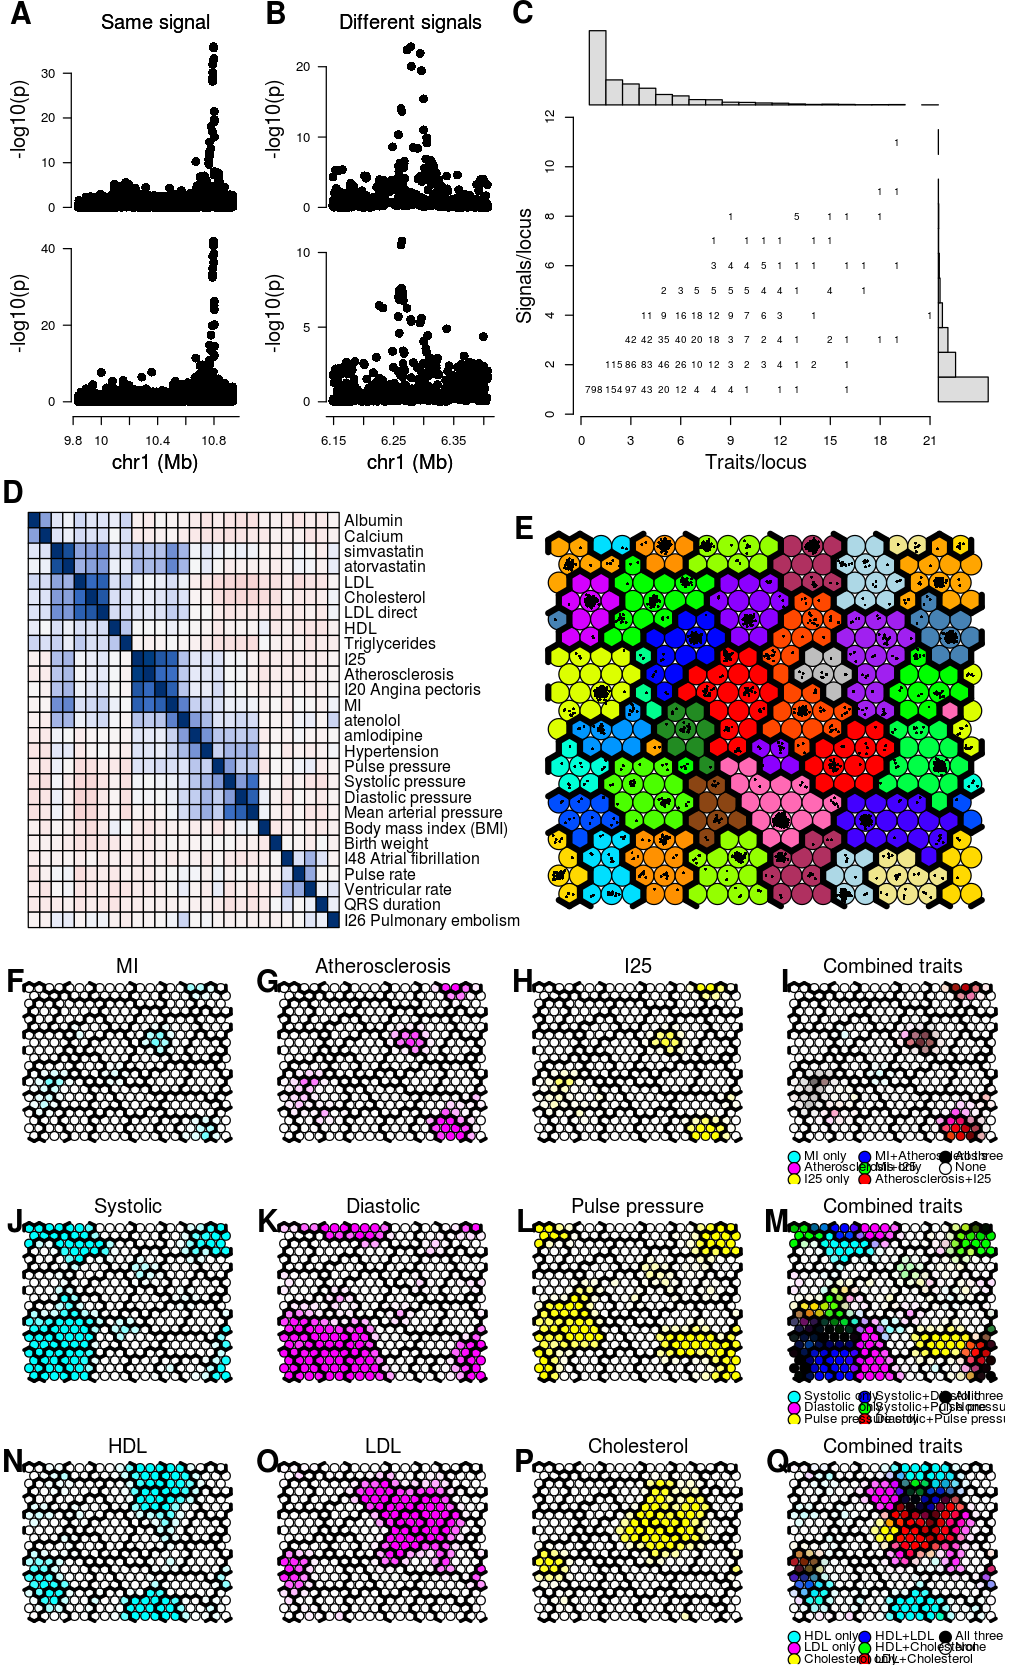

In [27]:
plot_som_clusters = function()
{
    set.seed(222)
    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_S1.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
    
    map      = moloc_map_list[["som"]][["map"     ]]
    g        = moloc_map_list[["som"]][["som_grid"]]
    clusters = moloc_map_list[["som"]][["clusters"]]
    
    par(mar = c(1,1,1,1))
    plot(map, type = "mapping", bgcol = pretty_palette(length(unique(clusters)))[clusters], main = "", pchs = 16, cex = 0.5) 
    add.cluster.boundaries(map, clusters)
    
    if(to_png == TRUE ){dev.off()}
}


plot_som_trait = function(ii, clusters)
{
    plot(map, type = "property", property = getCodes(map)[,ii], palette.name = colors, main = "", heatkey = FALSE)
    mtext(text = manifest[ii, "name"], side = 3, line = -0.75, cex = 1.5)
    add.cluster.boundaries(map, clusters, lwd = 3)
}

figure_1c = function()
{
    toplot   = aggregate(locus ~ n_signif + n_signals, data = moloc_df, FUN = length)
    toplot_x = aggregate(locus ~ n_signif            , data = moloc_df, FUN = length)
    toplot_y = aggregate(locus ~            n_signals, data = moloc_df, FUN = length)
    
    par(mar = c(4, 4, 1, 1))
    plot(1,1, type = "n", xlim = c(0, max(toplot$n_signif) + 3) + 0.5, ylim = c(0, max(toplot$n_signals) + 4) + 0.5, xlab = "", ylab = "", axes = FALSE)
    axis(1, at = (0:7) * 3)
    axis(2, at = (0:6) * 2)
    
    toplot[toplot$n_signif == 1 & toplot$n_signals == 1, "n_signif"] = 0.8
    
    text(x = toplot$n_signif, y = toplot$n_signals, labels = toplot$locus, cex = 0.75)
    
    rect(xleft   = max(toplot$n_signif ) + 0.5, xright = max(toplot$n_signif ) + 0.5 + 3 * toplot_y$locus / max(toplot_y$locus), ybottom = toplot_y$n_signals - 0.5, ytop   = toplot_y$n_signals + 0.5, col = "#dddddd")
    rect(ybottom = max(toplot$n_signals) + 1.5, ytop   = max(toplot$n_signals) + 1.5 + 3 * toplot_x$locus / max(toplot_x$locus), xleft   = toplot_x$n_signif  - 0.5, xright = toplot_x$n_signif  + 0.5, col = "#dddddd")
    
    mtext(text = "Traits/locus" , side = 1, line = 2.5, at = (max(toplot$n_signif )    ) / 2)
    mtext(text = "Signals/locus", side = 2, line = 2.5, at = (max(toplot$n_signals) + 1) / 2)
    mtext(text = "C"            , side = 2, line = 2.5, at = (max(toplot$n_signals ) + 4.5) * 1.05, font = 2, cex = 1.5, las = 2)
}

plot_pval_locus_simple = function(toplot, variant_id, mycol, ylab, xlims = c(), offset = 0, ylim = 0, draw_plot = TRUE, plot_title = "", chrom = "", panel = "")
{
    id             = variant_id
    sumstats       = toplot
    sumstats$mycol = sumstats[, mycol]
    mymar          = c(1,4.5,1,1)
    
    if(mycol     == "pval"){sumstats$mycol = -log10(sumstats$mycol)}
    if(ylim      == 0     ){ylims          = c(0, max(sumstats$mycol))}
    if(ylim      != 0     ){ylims          = c(0, ylim)}
    
    ylims[[2]] = ylims[[2]]*1.1
    ylim = ylims[[2]]
    if((ylim > 0.7)&(ylim <= 1.1)){ylim = 1.1}
    sumstats$mycol = sumstats$mycol / ylim + offset
    
    sumstats$cex = 1.5
    sumstats$pch = 16
    sumstats$bg  = NA
    
    sumstats[sumstats$id == id, "cex"] = 2.5
    sumstats[sumstats$id == id, "bg" ] = "#ff00ff"
    sumstats[sumstats$id == id, "pch"] = 23
    
    if(draw_plot == TRUE)
    {
        toax = pretty(c(0, ylim), n = 3)
        toax = toax[toax <= ylim]
        axis(2, at = toax / ylim + offset, labels = toax, las = 2)

        mypos = 2

        points(sumstats$pos, sumstats$mycol, pch = sumstats$pch, bg = sumstats$bg, cex = sumstats$cex)

        mtext(text = ylab                , side = 2, line =  2.75, at =  offset + 0.5)
        mtext(text = plot_title          , side = 3, line = -1  )
        mtext(text = paste(chrom, "(Mb)"), side = 1, line =  2.5)
        mtext(text = panel               , side = 2, line =  2.5 , at = (offset + 1  ) * 1.05, cex = 1.5, font = 2, las = 2)
    }
}

plot_gwas_example = function(locus, signal_ids, traits, xlims = c(), plot_title = "", chrom = "", panel = "")
{
    tolegend = FALSE
    
    toplot1      = meta_list[[signal_ids[[1]]]][["gwas_data"]][[traits[[1]]]]
    toplot1$pos  = as.numeric(unlist(lapply(toplot1$id, function(x){unlist(strsplit(x, "_"))[[3]]})))
    toplot1$pval = toplot1$pval_meta
    toplot1      = toplot1[ order(toplot1$pval, decreasing = TRUE),]
    
    toplot2      = meta_list[[signal_ids[[2]]]][["gwas_data"]][[traits[[2]]]]
    toplot2$pos  = as.numeric(unlist(lapply(toplot2$id, function(x){unlist(strsplit(x, "_"))[[3]]})))
    toplot2$pval = toplot2$pval_meta
    toplot2      = toplot2[ order(toplot2$pval, decreasing = TRUE),]
    
    par(mar = c(4,4.5,1,1))
    plot(1,1, type = "n", xlim = xlims, ylim = c(0, 2.1), xlab = "", ylab = "", axes = FALSE)
    
    axis(1, at = pretty(xlims, n = 5), labels = pretty(xlims, n = 5) * 1e-6)
    
    variant_id = ""
    
    plot_pval_locus_simple(toplot1, variant_id, "pval"  , "-log10(p)", xlims, 1.1, 0, TRUE, plot_title, chrom, panel)
    plot_pval_locus_simple(toplot2, variant_id, "pval"  , "-log10(p)", xlims, 0  , 0, TRUE, plot_title, chrom, "")
}

figure_cor_traits = function(cordata, clustdata)
{
    cordata           = cordata[clustdata$order, clustdata$order]
    colnames(cordata) = manifest[colnames(cordata), "name"]
    colnames(cordata) = gsub(paste(c(" cholesterol", " adjusted by medication", " blood", " Chronic ischaemic heart disease", "Coronary "), collapse = "|"), "", 
                             gsub("Myocardial infarction", "MI", gsub("atherosclerosis", "Atherosclerosis", gsub(" and flutter", "", colnames(cordata)))))
    
    par(mar = c(1,1,1,10))
    plot(1,1, type = "n", xlim = c(0, nrow(cordata)), ylim = c(nrow(cordata), 0), xlab = "", ylab = "", axes = FALSE) 
    
    for(ii in 1:nrow(cordata))
    {
        rect(xleft = ii - 1, xright = ii, ybottom = (1:ncol(cordata)) - 1, ytop = 1:ncol(cordata), col = values2color(as.numeric(cordata[ii,]), colorscale = diverge_hcl(n = 100, palette = "Blue-Red 3", rev = TRUE), minval = -1, maxval = 1))
    }
    
    mtext(text = colnames(cordata), side = 4, line = -0.5, at = (1:ncol(cordata)) - 0.5 , cex = 0.8, las = 2)
    mtext(text = "D"              , side = 2, line = -0.5, at = -nrow(cordata)    * 0.05, cex = 1.5, las = 2, font = 2)
}

figure_som_clusters = function()
{
    map      = moloc_map_list[["som"]][["map"     ]]
    g        = moloc_map_list[["som"]][["som_grid"]]
    clusters = moloc_map_list[["som"]][["clusters"]]
    
    par(mar = c(4,4,1,1))
    plot(map, type = "mapping", bgcol = pretty_palette(length(unique(clusters)))[clusters], main = "", pchs = 16, cex = 0.5) 
    add.cluster.boundaries(map, clusters)
    
    mtext(text = "E", side = 2, line =  2.5 , at = max(g[["pts"]][,2]) * 1.05, cex = 1.5, font = 2, las = 2)
}

figure_som_overlap = function(traits, panels = rep("", 4))
{
    map             = moloc_map_list[["som"]][["map"     ]]
    g               = moloc_map_list[["som"]][["som_grid"]]
    clusters        = moloc_map_list[["som"]][["clusters"]]
    #clusters        = kmeans(x = map$codes[[1]], centers = 30, iter.max = 500, nstart = 10)$cluster
    codes           = map[["codes"]][[1]]
    codes           = as.data.frame(255 - ceiling(codes * 255))
    colnames(codes) = manifest$id
    codes2col       = codes
    
    for(trait in traits)
    {
        codes[,trait] = as.character(as.hexmode(codes[, trait]))
    }
    
    toplot          = cbind(as.data.frame(g[["pts"]]), codes[,traits])
    toplot$color    = apply(as.matrix(toplot[,traits]), 1, function(x){paste(c("#", x), collapse = "")})
    
    color_start = rep("ff", 3)
    
    for(ii in 1:length(traits))
    {
        trait         = traits[[ii]]
        tocol         = toplot
        mycolor       = color_start
        mycolor[[ii]] = "00"
        mycolor       = paste(c("#", mycolor), collapse = "")
        tocol$color   = values2color((255 - codes2col[,trait]) / 255, colorscale = colorpanel(n = 100, low = "#ffffff", high = mycolor), minval = 0, maxval = 1)
        
        par(mar = c(1,1,1,1))
        plot(1,1, type = "n", xlim = c(min(tocol$x) - 0.5, max(tocol$x) + 0.5), ylim = c(min(tocol$y) - 4.5, max(tocol$y) + 0.5), axes = FALSE)

        points(x = tocol$x, y = tocol$y, cex = 1.5, pch = 21, bg = tocol$color)
        
        name = gsub(paste(c(" cholesterol", " adjusted by medication", " blood pressure", " Chronic ischaemic heart disease", "Coronary "), collapse = "|"), "", 
                         gsub("Myocardial infarction", "MI", gsub("atherosclerosis", "Atherosclerosis", manifest[trait, "name"])))
        
        add.cluster.boundaries(map, clusters, lwd = 3)  
        mtext(text = panels[[ii]], side = 2, line = -0.5, at = max(tocol$y) * 1.05, font = 2, cex = 1.5, las = 2)
        mtext(text = name        , side = 3, line =  0)
    }

    par(mar = c(1,1,1,1))
    plot(1,1, type = "n", xlim = c(min(toplot$x) - 0.5, max(toplot$x) + 0.5), ylim = c(min(toplot$y) - 4.5, max(toplot$y) + 0.5), axes = FALSE)

    points(x = toplot$x, y = toplot$y, cex = 1.5, pch = 21, bg = toplot$color)

    add.cluster.boundaries(map, clusters, lwd = 3)  
    
    mylegend = manifest[traits, "name"]
    mylegend = data.frame(name = c(paste(mylegend, "only"), 
                                   paste(mylegend[[1]], mylegend[[2]], sep = "+"), 
                                   paste(mylegend[[1]], mylegend[[3]], sep = "+"),
                                   paste(mylegend[[2]], mylegend[[3]], sep = "+"),
                                   "All three traits", "None"
                                  ),
                          color = c("#00ffff", "#ff00ff", "#ffff00",
                                    "#0000ff", "#00ff00", "#ff0000",
                                    "#000000", "#ffffff"
                                   ),
                          x = c(1,1,1,8,8,8,16, 16),
                          y = c(-1.5, -2.75, -4, -1.5, -2.75, -4, -1.5, -2.75)
                         )
    
    mylegend$name = gsub(paste(c(" cholesterol", " adjusted by medication", " blood pressure", " Chronic ischaemic heart disease", "Coronary "), collapse = "|"), "", 
                         gsub("Myocardial infarction", "MI", gsub("atherosclerosis", "Atherosclerosis", mylegend$name)))
    
    points(x = mylegend$x      , y = mylegend$y, bg     = mylegend$color, pch = 21, cex = 2)
    text  (x = mylegend$x + 0.2, y = mylegend$y, labels = mylegend$name , pos =  4)
    
    mtext(text = panels[[4]]      , side = 2, line = -0.5, at = max(toplot$y) * 1.05, font = 2, cex = 1.5, las = 2)
    mtext(text = "Combined traits", side = 3, line =  0)
}


figure_1 = function(size_x = 8.5, size_y = 14,to_png = FALSE)
{
    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_1.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
    
    mylayout = rbind(c(1,2,3,3), 
                     c(1,2,3,3), 
                     c(4,4,5,5),
                     c(4,4,5,5),
                     6:9,
                     10:13,
                     14:17
                    )
    layout(mylayout)
    
    
    plot_gwas_example  ("1_9830927_10934579", c("1_9830927_10934579.1", "1_9830927_10934579.1"), c('continuous-DBP-both_sexes-combined_medadj_irnt', 'continuous-SBP-both_sexes-combined_medadj_irnt'), c(9830927, 10934579), "Same signal"      , "chr1", "A")
    plot_gwas_example  ("1_6148182_6406912" , c("1_6148182_6406912.1" , "1_6148182_6406912.2" ), c('continuous-102-both_sexes-irnt'                , 'continuous-PP-both_sexes-combined_medadj_irnt' ), c(6148182,  6406912), "Different signals", "chr1", "B")
    figure_1c          ()
    figure_cor_traits  (cordata_cor, cluster_cor)
    figure_som_clusters()
    
    traits_b = c("phecode-411.2-both_sexes", "phecode-411.4-both_sexes", "icd10-I25-both_sexes")
    traits_c = c("continuous-SBP-both_sexes-combined_medadj_irnt", "continuous-DBP-both_sexes-combined_medadj_irnt", "continuous-PP-both_sexes-combined_medadj_irnt")
    #traits_d = c("biomarkers-30760-both_sexes-irnt", "continuous-LDLC-both_sexes-medadj_irnt", "biomarkers-30870-both_sexes-irnt")
    traits_d = c("biomarkers-30760-both_sexes-irnt", "continuous-LDLC-both_sexes-medadj_irnt", "biomarkers-30690-both_sexes-irnt")
    
    figure_som_overlap(traits_b, LETTERS[(1:4) +  5])
    figure_som_overlap(traits_c, LETTERS[(1:4) +  9])
    figure_som_overlap(traits_d, LETTERS[(1:4) + 13])

    if(to_png == TRUE ){dev.off()}
}

figure_1(to_png = FALSE)
#figure_1(to_png = TRUE )


## Figure 2: Fine mapping of GWAS traits
- A: fine mapping credible set sizes
- B-D: fine mapping examples (missing one novel)

png 
  2

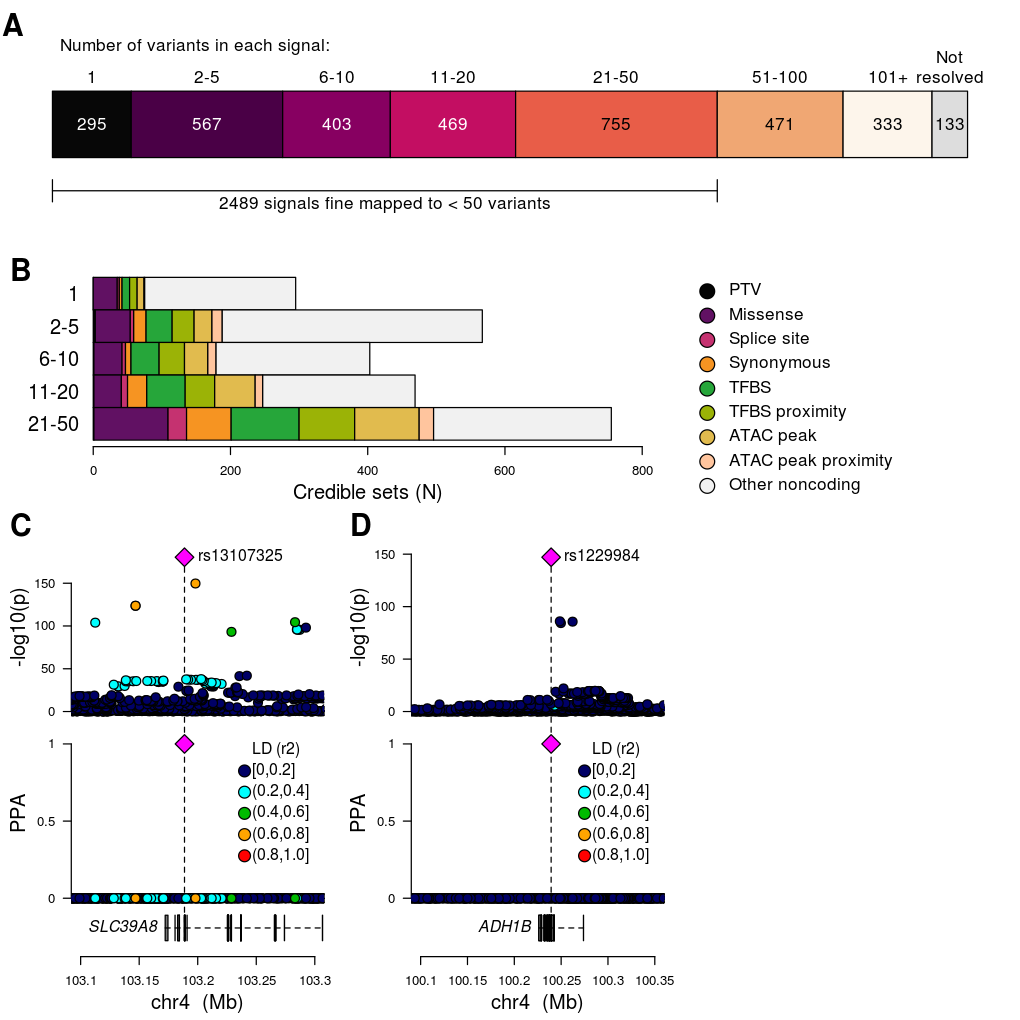

In [28]:
figure_fm_numbers = function()
{
    toplot            = aggregate(credible_set ~ bin + from + to + bin_name, data = signal2bin, FUN = length)
    toplot            = toplot[order(toplot$bin),]
    toplot$color      = c(sequential_hcl(n = nrow(toplot) - 1, palette = "Rocket", rev = FALSE), "#dddddd")
    toplot$font_color = c(rep("#ffffff", 4), rep("#000000", nrow(toplot) - 4))
    toplot$offset     = unlist(lapply(1:nrow(toplot), function(ii){sum(toplot[1:(ii), "credible_set"]) - toplot[ii, "credible_set"]}))
    
    par(mar = c(0,1,1,1))
    plot(1,1, type = "n", xlim = c(0, nrow(signal2bin)), ylim = c(0, 1), xlab = "", ylab = "", axes = FALSE)
    
    rect(xleft = toplot$offset, xright = toplot$credible_set + toplot$offset, ybottom = 0.4, ytop = 0.7, col = toplot$color)
    
    snps50          = sum(toplot[toplot$to <= 50 & toplot$bin_name != "Not resolved", "credible_set"])
    toplot$bin_name = sub("Not ", "Not\n", toplot$bin_name)
    
    segments(x0 = 0, x1 = snps50, y0 = 0.25)
    segments(x0 = c(0, snps50)  , y0 = 0.2 , y1 = 0.3)
    
    
    text(x = toplot$offset + toplot$credible_set / 2, y = 0.7 , cex = 1.3, pos = 3, labels = toplot$bin_name    )
    text(x = toplot$offset + toplot$credible_set / 2, y = 0.55, cex = 1.3,          labels = toplot$credible_set, col = toplot$font_color)
    text(x = 0                                      , y = 0.9 , cex = 1.3, pos = 4, labels = "Number of variants in each signal:")
    text(x = snps50 / 2                             , y = 0.25, cex = 1.3, pos = 1, labels = paste(snps50, "signals fine mapped to < 50 variants"))
    
    mtext(text = "A", side = 2, line = -0.5, at = 1, font = 2, cex = 1.5, las = 2)
}

figure_fm_annot = function()
{
    toplot = as.data.frame.matrix(table(cs_annot_by_signal[,c("vartype", "bin_name")]))
    cs2bin = cs2bin[ cs2bin$bin_name %in% colnames(toplot),]
    toplot = toplot[ vartypes$vartype, cs2bin$bin_name]
    
    rownames(toplot) = vartypes$varname
    colnames(toplot) = cs2bin  $bin_name
    
    toplot = as.data.frame(t(as.matrix(toplot)))
    
    par(mar = c(4,4.5,1,1))
    plot(1,1, type = "n", xlim = c(0, 800), ylim = c(nrow(toplot), 0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    
    mtext(text = "Credible sets (N)", side = 1, line =  2.5)
    mtext(text = rownames(toplot)   , side = 2, line = -0.5, las = 2, at = cs2bin$bin - 0.5)
    mtext(text = "B"                , side = 2, line =  2.5, las = 2, at = -(nrow(toplot)) * 0.05, font = 2, cex = 1.5)
    
    barplot(t(as.matrix(toplot)), width = 1, space = 0, names.arg = rep(NA, nrow(toplot)), horiz = TRUE, add = TRUE, col = vartypes$color, axes = FALSE)
    
    par(mar = c(1,1,1,1))
    plot(1,1, type = "n", xlim = c(0, 1), ylim = c(nrow(vartypes), 0.5), xlab = "", ylab = "", axes = FALSE)
    
    vartypes$varname = sub("Other", "Other noncoding", vartypes$varname)
    
    points(x = rep(0   , nrow(vartypes)), y = vartypes$order, bg     = vartypes$color  , pch = 21, cex = 2.5)
    text  (x = rep(0.05, nrow(vartypes)), y = vartypes$order, labels = vartypes$varname, pos =  4, cex = 1.3)
}

plot_genes = function(genes, locus, loci, xlims = c(), panel = "")
{
    chrom   = paste0("chr", unlist(strsplit(locus, "_"))[[1]])
    genes   = genes[order(genes$start),]
    myx     = genes$end
    mypos   = 4
    
    if(myx > (xlims[[1]] + (xlims[[2]] - xlims[[1]]) / 2))
    {
        myx   = genes$start
        mypos = 2
    }
    
    exons = exons[ exons$gene_id %in% genes$gene_id, ]
    
    axis(1, at = pretty(xlims, n = 5), labels = pretty(xlims, n = 5) * 1e-6)
    
    mtext(text = paste(chrom, " (Mb)"), side = 1, line = 2.5)
    
    rect(xleft = exons$start, xright = exons$end, ybottom = -0.25, ytop = -0.1, col = "#777777", bg = "#777777")
    text(x     = myx        , y      = -0.175   , labels  = genes$gene_name, font = 3, pos = mypos, cex = 1.2)
    
    segments(x0 = genes$start, x1 = genes$end, y0 = -0.175, lty = "dashed")
    #segments(x0 = genes$x, x1 = genes$start + (genes$end - genes$start) / 2, y0 = -genes$y, y1 = -0.8, lty = "dashed")
    mtext(text = panel, side = 2, line = 2.5, cex = 2, at = 1, font = 2, las = 2)
}

plot_pval_locus = function(toplot, rsid, variant_id, mycol, ylab, xlims = c(), offset = 0, ylim = 0, draw_legend = FALSE, draw_plot = TRUE, panel = "")
{
    id             = variant_id
    sumstats       = toplot
    sumstats$mycol = sumstats[, mycol]
    mymar          = c(1,4.5,1,1)
    
    if(mycol     == "pval"){sumstats$mycol = -log10(sumstats$mycol)}
    if(ylim      == 0     ){ylims          = c(0, max(sumstats$mycol))}
    if(ylim      != 0     ){ylims          = c(0, ylim)}
    
    ylims[[2]] = ylims[[2]]*1.1
    ylim = ylims[[2]]
    if((ylim > 0.7)&(ylim <= 1.1)){ylim = 1.1}
    sumstats$mycol = sumstats$mycol / ylim + offset
    
    sumstats$cex = 1.5
    sumstats$pch = 21
    sumstats$bg  = values2color(sumstats$r2, c("#000066", "#00ffff", "#00bb00", "#ffa500", "#ff0000"), 0, 1)
    
    sumstats[sumstats$id == id, "cex"] = 2.5
    sumstats[sumstats$id == id, "bg" ] = "#ff00ff"
    sumstats[sumstats$id == id, "pch"] = 23
    
    if(draw_plot == TRUE)
    {
        toax = pretty(c(0, ylim), n = 3)
        toax = toax[toax <= ylim]
        axis(2, at = toax / ylim + offset, labels = toax, las = 2)

        mypos = 2
        
        if(panel != "")
        {
            segments(x0 = sumstats[sumstats$id == id, "pos"], y0 = sumstats[sumstats$id == id, "mycol"], y1 = -0.25, lty = "dashed")
            text(x = sumstats[sumstats$id == id, "pos"] + 5000, y = sumstats[sumstats$id == id, "mycol"], labels = rsid, pos = 4, cex = 1.2)
        }

        points(sumstats$pos, sumstats$mycol, pch = sumstats$pch, bg = sumstats$bg, cex = sumstats$cex)

        mtext(text = ylab , side = 2, line = 2.75, at = offset + 0.5)
        mtext(text = panel, side = 2, line = 2.5 , at = offset + 1.1, cex = 1.5, font = 2, las = 2)

        totext = sumstats[sumstats$variant_id == id,]
        
        if(nrow(totext[totext$rsid == "rs10774671",]) > 0){mypos = 4}

        if (name == "coloc PP"){text(x = totext$pos, y = totext$mycol, labels = rsid, pos = mypos, cex = 1.5)}
        
        if(draw_legend == TRUE)
        {
            points(x = rep(xlims[[1]] + (xlims[[2]] - xlims[[1]]) * 0.7, 5), y = c(5:1 + 1) / 8, pch = 21, bg = c("#000066", "#00ffff", "#00bb00", "#ffa500", "#ff0000"), cex = 2)
            text  (x = rep(xlims[[1]] + (xlims[[2]] - xlims[[1]]) * 0.7, 6), y = c(6:1 + 1) / 8, labels = c("LD (r2)", "[0,0.2]", "(0.2,0.4]", "(0.4,0.6]", "(0.6,0.8]", "(0.8,1.0]"), pos = 4, cex = 1.2)
        }
    }
}

plot_by_gene_finemap = function(locus, variant_id, rsid, gene_id, ld_file, xlims = c(), panel = "")
{
    tolegend = FALSE
    
    indata     = meta_list[[locus]]
    toplot     = indata[["finemapped_gwas"]][["pp"]]
    toplot     = toplot[toplot$id != "null",]
    lddata     = fread(ld_file, sep = "\t", header = TRUE, data.table = FALSE)
    toplot     = merge(toplot[,c("id", "pval", "pp_snp")], lddata[,c("id", "rsid", "r2")], all.x = TRUE)
    toplot$pos = as.numeric(unlist(lapply(toplot$id, function(x){unlist(strsplit(x, "_"))[[3]]})))
    toplot     = toplot[ order(toplot$pp_snp, decreasing = FALSE),]
    
    toplot[ is.na(toplot$r2  ) == TRUE, "r2"  ] = 0
    toplot[ is.na(toplot$rsid) == TRUE, "rsid"] = toplot[ is.na(toplot$rsid) == TRUE, "id"]
    
    par(mar = c(4,4.5,1,1))
    plot(1,1, type = "n", xlim = xlims, ylim = c(-0.25, 2.1), xlab = "", ylab = "", axes = FALSE)
    
    plot_pval_locus(toplot, rsid, variant_id, "pval"  , "-log10(p)", xlims, 1.1, 0, FALSE, TRUE, panel)
    plot_pval_locus(toplot, rsid, variant_id, "pp_snp", "PPA"      , xlims, 0  , 0, TRUE , TRUE, "")
    plot_genes(gene_info[gene_info$gene_id == gene_id,], locus, loci, xlims, "")
}

figure_2 = function(size_x = 8.5, size_y = 8.5,to_png = FALSE)
{
    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_2.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
    
    mylayout = rbind(rep(1,3), c(2,2,3), 4:6, 4:6)
    layout(mylayout)
    
    figure_fm_numbers()
    
    figure_fm_annot()
    
    plot_by_gene_finemap("4_101904130_104478012.1", "VAR_4_103188709_C_T", "rs13107325", "ENSG00000138821.13_6", "pipeline/5.7.ld_for_figures/rs13107325.txt", c(103.1 , 103.3 ) * 1e6, "C")
    plot_by_gene_finemap("4_99841138_100760909.1" , "VAR_4_100239319_T_C", "rs1229984" , "ENSG00000196616.14_6", "pipeline/5.7.ld_for_figures/rs1229984.txt" , c(100.1 , 100.35) * 1e6, "D")

    if(to_png == TRUE ){dev.off()}
}

figure_2(to_png = FALSE)
figure_2(to_png = TRUE )

# add C: variants by PPA
# 3 examples:  one with PTV; one that disrupts a TFBS + one splice site

# random variants: match coding/non-coding; same GC content; same substitution types

# add 51-100
# look for overlap +/- 50 bp. How is ASE?
# B: only coding
# figure 3: ATAC
# Figure 4: eQTLs
# Figure 5: pull all together

In [29]:
toplot = as.data.frame.matrix(table(cs_annot_by_signal[,c("vartype", "bin_name")]))
t(as.matrix(toplot))

toplot = t(as.matrix(toplot)) / colSums(toplot) * 100

toplot

atac atac100 missense noncoding PTV splice_site synonymous tfbs tfbs100
1     10    1       35      220       0    3           4         11   11     
11-20 59   11       40      222       1    9          28         56   43     
2-5   26   15       51      379       3    5          18         38   32     
21-50 94   21      108      259       1   27          65         99   81     
6-10  34   12       41      224       1    5           8         41   37

atac      atac100   missense  noncoding PTV       splice_site synonymous
1      3.389831 0.3389831 11.864407 74.57627  0.0000000 1.0169492   1.355932  
11-20 12.579957 2.3454158  8.528785 47.33475  0.2132196 1.9189765   5.970149  
2-5    4.585538 2.6455026  8.994709 66.84303  0.5291005 0.8818342   3.174603  
21-50 12.450331 2.7814570 14.304636 34.30464  0.1324503 3.5761589   8.609272  
6-10   8.436725 2.9776675 10.173697 55.58313  0.2481390 1.2406948   1.985112  
      tfbs      tfbs100  
1      3.728814  3.728814
11-20 11.940299  9.168443
2-5    6.701940  5.643739
21-50 13.112583 10.728477
6-10  10.173697  9.181141

In [30]:
rowSums(toplot)

1 11-20   2-5 21-50  6-10 
  100   100   100   100   100

## Figure S1: Mapping each GWAS trait to the Kohonen SOM

png 
  2

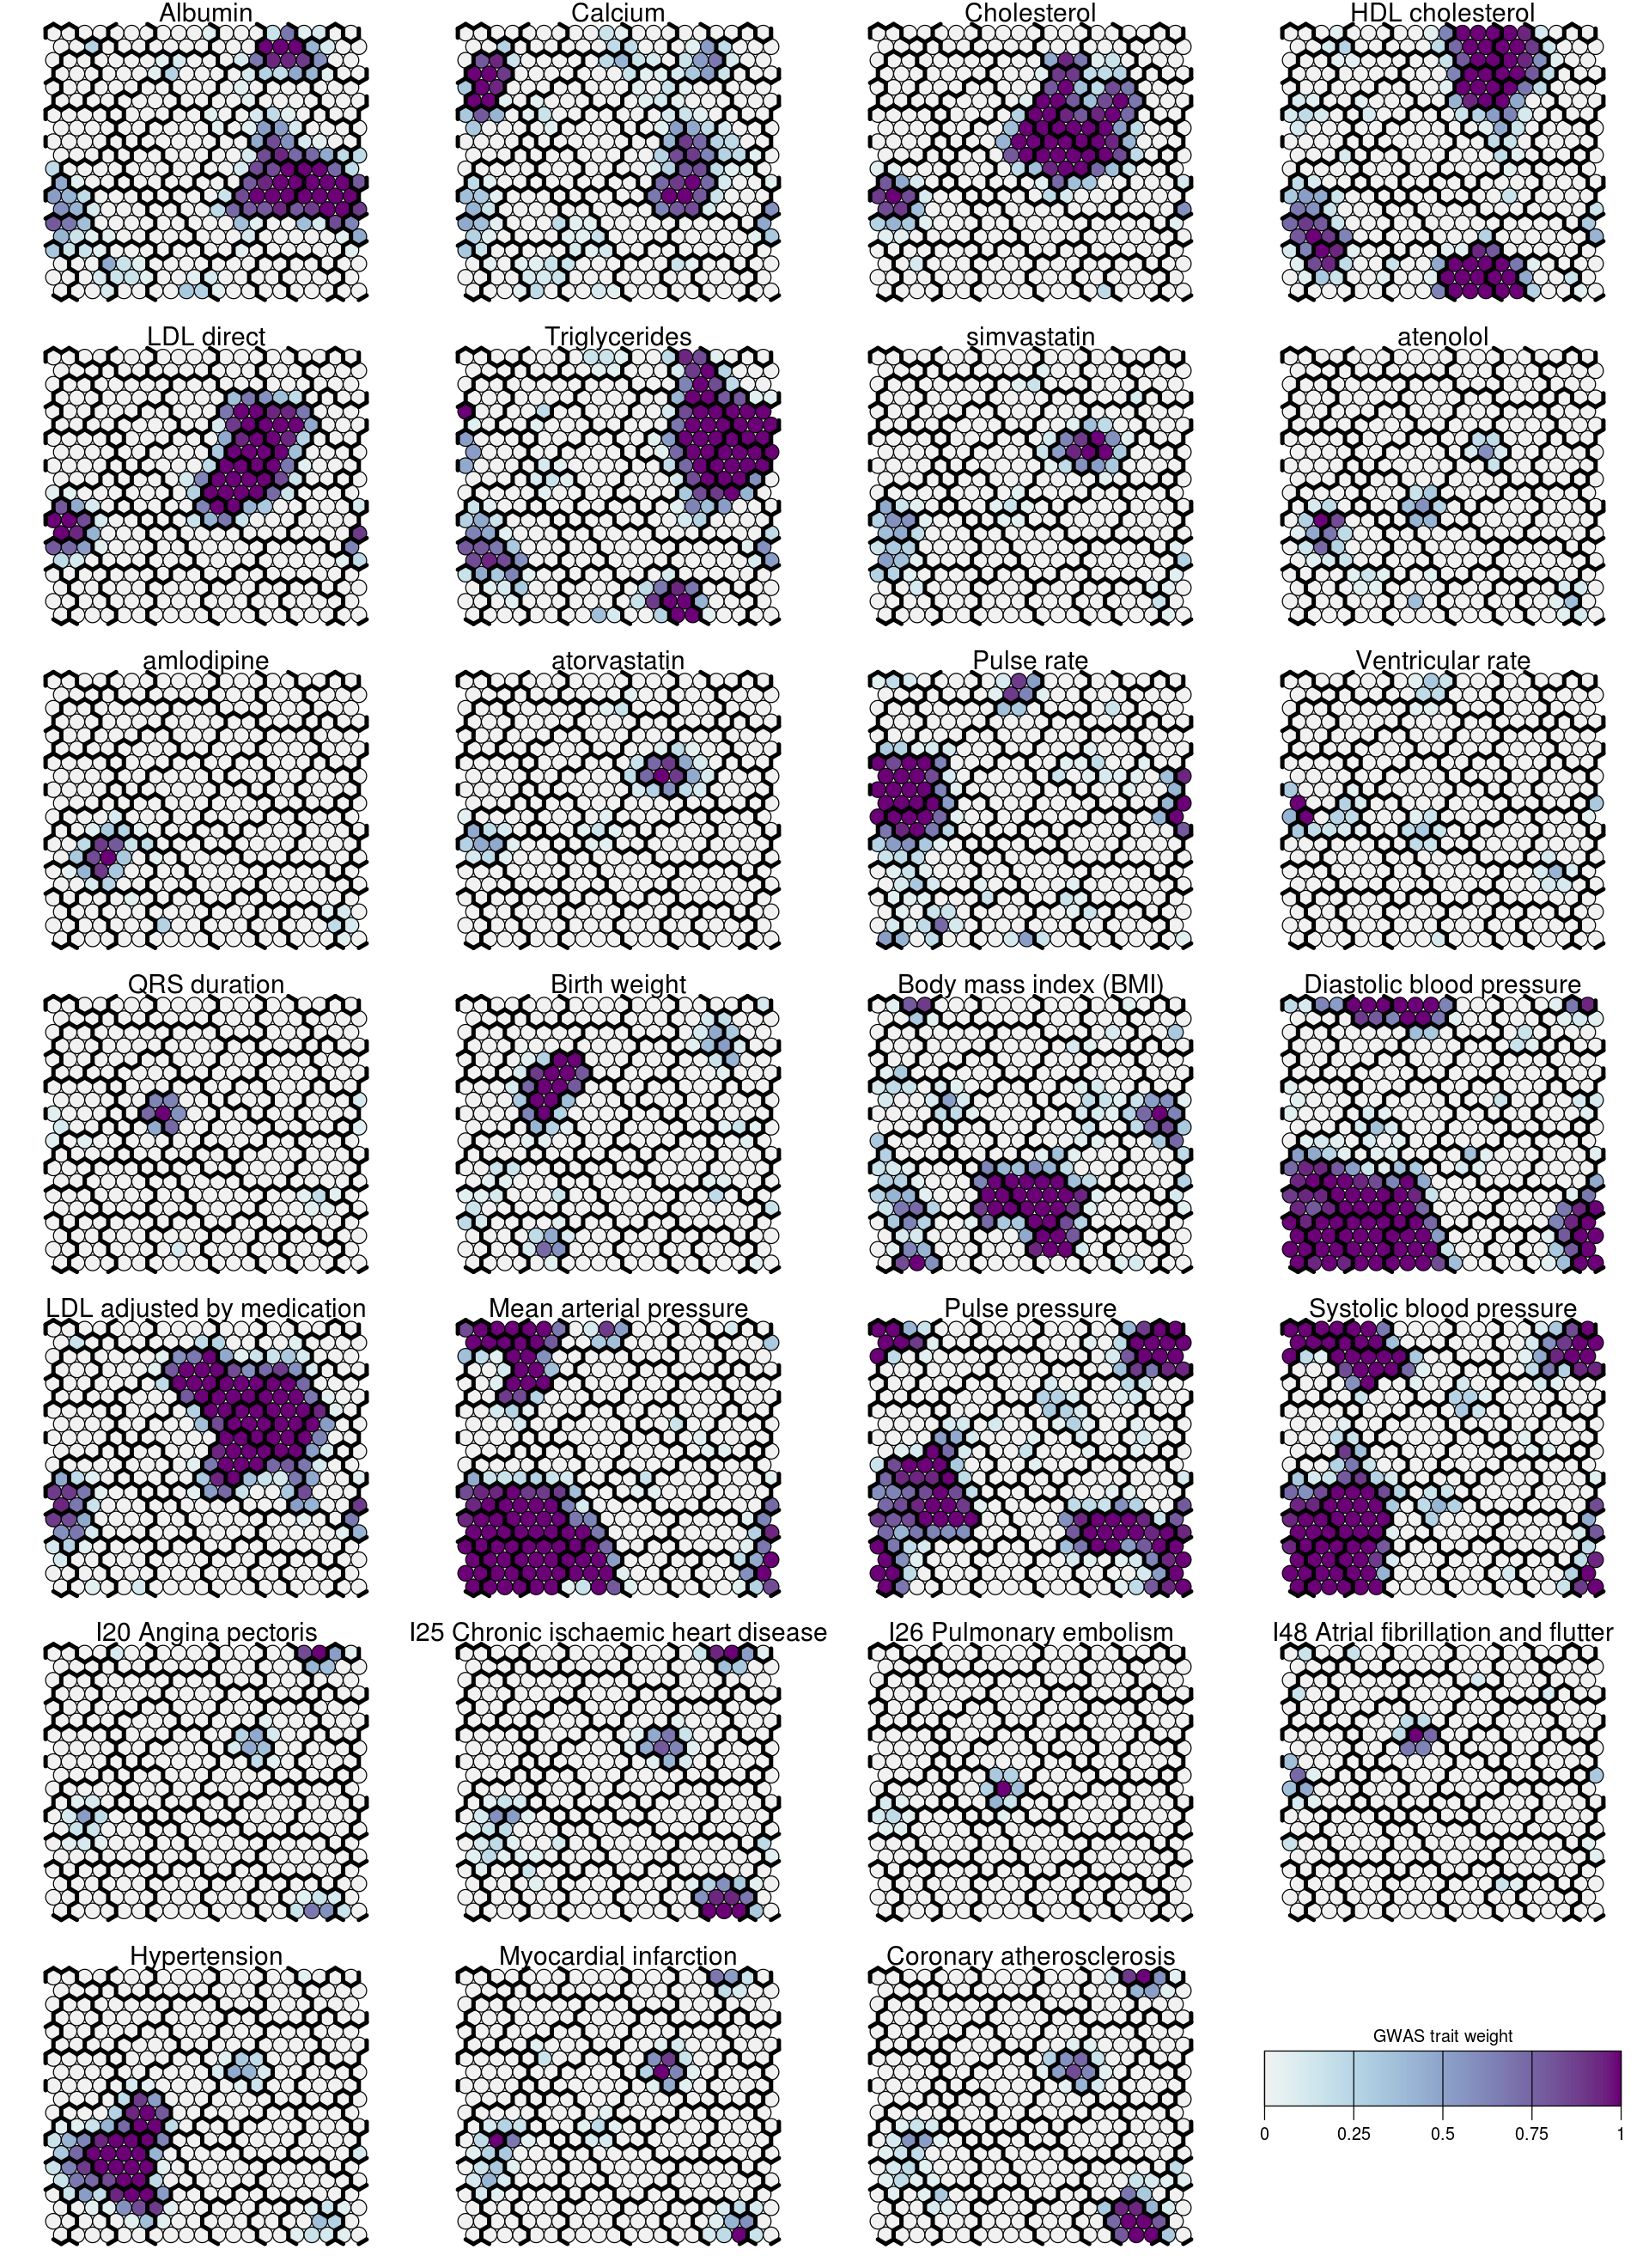

In [31]:
colors = function(n, alpha = 1)
{
    sequential_hcl(n = n, alpha = alpha, palette = "Purple-Blue", rev = TRUE)
}

plot_som_trait = function(ii, map, clusters)
{
    plot(map, type = "property", property = getCodes(map)[,ii], palette.name = colors, main = "", heatkey = FALSE)
    mtext(text = manifest[ii, "name"], side = 3, line = -0.75, cex = 1.5)
    add.cluster.boundaries(map, clusters, lwd = 4)
}

figure_s1 = function(size_x = 16, size_y = 22,to_png = FALSE)
{
    set.seed(222)
    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_S1.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
    
    map      = moloc_map_list[["som"]][["map"     ]]
    g        = moloc_map_list[["som"]][["som_grid"]]
    g        = moloc_map_list[["som"]][["clusters"]]
    #clusters = kmeans(x = map$codes[[1]], centers = 30, iter.max = 500, nstart = 10)$cluster
    
    layout(matrix(1:28, nrow = 7, byrow = TRUE))
    
    par(mar = c(1,1,1,1))
    invisible(lapply(1:nrow(manifest), function(ii){plot_som_trait(ii, map, clusters)}))
    
    plot(1,1, type = "n", xlim = c(0,1), ylim = c(0,1), axes = FALSE)
    
    rect(xleft = (0:99) / 100, xright = (1:100) / 100, ybottom = 0.5, ytop = 0.7, col = colors(100), border = NA)
    rect(xleft = 0           , xright = 1            , ybottom = 0.5, ytop = 0.7)
    
    segments(x0 = (0:4) / 4, y0 = 0.45, y1 = 0.7)
    text    (x  = (0:4) / 4, y  = 0.4 , labels = (0:4) / 4, cex = 1.5)
    text    (x  = 0.5      , y  = 0.75, labels = "GWAS trait weight", cex = 1.5)
    
    if(to_png == TRUE ){dev.off()}
}

figure_s1(to_png = FALSE)
figure_s1(to_png = TRUE )




## Figure S2: fine mapped variants with high PPA are more likely to overlap or be close to TFBS

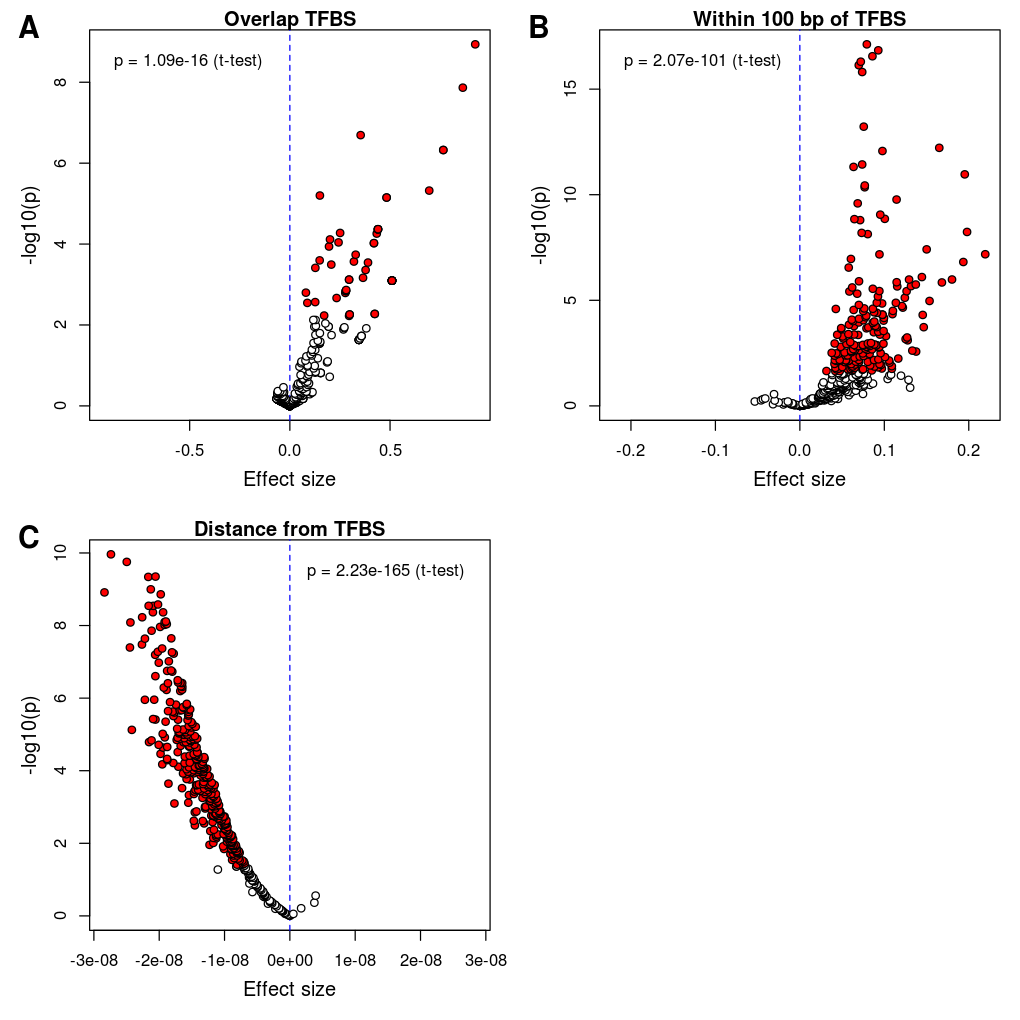

In [32]:
plot_volcano = function(x, test_overlap, name, panel = "")
{
    toplot   = test_overlap[ test_overlap$motif != "atac",]
    toplot$x =        toplot[,paste(x, "beta", sep = ".")]
    toplot$y = -log10(toplot[,paste(x, "pval", sep = ".")])
    toplot   = toplot[order(toplot$y),]
    
    toplot$color = "#ffffff"
    
    toplot[toplot[,paste(x, "qval", sep = ".")] <= 0.05, "color"] = "#ff0000"
    
    xlims    = max(abs(toplot$x))
    xlims    = c(-xlims, xlims)
    
    par(mar = c(4.5, 4.5, 1.5, 1))
    plot(1,1, type = "n", xlim = xlims, ylim = c(0, max(toplot$y)), xlab = "", ylab = "")
    
    abline(v = 0, lty = "dashed", col = "#0000ff")
    
    points(x = toplot$x, y = toplot$y, pch = 21, bg = toplot$color)
    
    mtext(text = panel        , side = 2, line = 2.5, font = 2, at = max(toplot$y) * 1.05, cex = 1.5, las = 2)
    mtext(text = "Effect size", side = 1, line = 2.5)
    mtext(text = "-log10(p)"  , side = 2, line = 2.5)
    mtext(text = name         , side = 3, line = 0  , font = 2)
    
    test  = t.test(toplot$x, mu = 0)
    myx   = ifelse(test$estimate > 0, yes = xlims[[1]], no = xlims[[2]])
    mypos = ifelse(test$estimate > 0, yes = 4         , no = 2         )
    
    text(x = myx, y = max(toplot$y) * 0.95, labels = paste0("p = ", signif(test$p.value, digits = 3), " (t-test)"), pos = mypos)
}

figure_s2 = function(size_x = 8.5, size_y = 8.5,to_png = FALSE)
{
    set.seed(222)
    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_S2.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
    
    layout(rbind(1:2, 3:4))
    
    plot_volcano("overlap"    , test_overlap, "Overlap TFBS"         , "A")
    plot_volcano("distance100", test_overlap, "Within 100 bp of TFBS", "B")
    return(plot_volcano("distance"   , test_overlap, "Distance from TFBS"   , "C"))


    
    if(to_png == TRUE ){dev.off()}
}

figure_s2(to_png = FALSE)
#igure_s2(to_png = TRUE )

# label top 10 TFs?

In [33]:
str(test_overlap)

'data.frame':	429 obs. of  18 variables:
 $ motif           : chr  "atac" "MA0002.2" "MA0003.4" "MA0007.3" ...
 $ name            : chr  "ATAC" "RUNX1" "TFAP2A" "AR" ...
 $ gene_id         : chr  "" "ENSG00000159216.18_7" "ENSG00000137203.14_6" "ENSG00000169083.17_8" ...
 $ gene_name       : chr  "" "RUNX1" "TFAP2A" "AR" ...
 $ overlap         : int  2052 3 10 3 2 2 1 0 2 1 ...
 $ distance100     : int  2340 73 108 16 41 37 14 5 49 21 ...
 $ overlap.beta    : num  0.0363 0.0292 -0.0363 0.3197 0.4195 ...
 $ overlap.se      : num  0.00345 0.08779 0.04809 0.08777 0.10749 ...
 $ overlap.pval    : num  7.69e-26 7.40e-01 4.51e-01 2.71e-04 9.53e-05 ...
 $ distance100.beta: num  0.0337 0.00708 0.04312 0.09258 0.11464 ...
 $ distance100.se  : num  0.00324 0.01781 0.01465 0.03802 0.02375 ...
 $ distance100.pval: num  2.89e-25 6.91e-01 3.25e-03 1.49e-02 1.39e-06 ...
 $ distance.beta   : num  -4.64e-08 -1.13e-08 -1.61e-08 -1.33e-08 -1.03e-08 ...
 $ distance.se     : num  1.61e-08 4.15e-09 4.02e-09

# Part 2: eQTLs

In [34]:
qtl2cell_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/pipeline/cell_type_associations/qtl2cell.rds")

In [35]:
for(x in names(qtl2cell_list))
{
    qtl2cell_list[[x]][,"by_tissue:ipsc_cvpc"] = NULL
    
    colnames(qtl2cell_list[[x]]) = gsub("by_organ:adult", "by_stage:adult", gsub("by_organ:ipsc_cvpc", "by_stage:ipsc_cvpc", colnames(qtl2cell_list[[x]])))
}

In [36]:
qtl2type = qtl_data$phenotypes

qtl2type = cbind(qtl2type[,c("phenotype", "name", "color")], as.data.frame(rbindlist(lapply(qtl2type$phenotype, function(phenotype)
{
    x     = qtl_data[["qtl"]][[phenotype]]
    types = 0:5
    out   = unlist(lapply(types, function(type){nrow(x[x$type == type & x$egene == TRUE, ])}))
    out   = c(length(unique(x$transcript_id)), out)
    out   = data.frame(matrix(out, nrow = 1))
    
    colnames(out) = c("Expressed", "Primary", paste("Conditional", 1:5))
    
    return(out)
})), stringsAsFactors = FALSE))

In [37]:
eqtl_coloc = list(isoform         = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.isoform.txt"      , sep = "\t", header = TRUE, data.table = FALSE),
                  gene            = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.gene.txt"         , sep = "\t", header = TRUE, data.table = FALSE),
                  isoform_vs_gene = fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.2.eqtls/eqtl_overlap/cardiac_eqtls.coloc_by_gene.txt", sep = "\t", header = TRUE, data.table = FALSE)
                 )

## Differences between gene and isoform eQTLs

In [38]:
rna_overlap  = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/pipeline/compare_qtls/overlap.rna.rds"     )
iso_overlap  = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/pipeline/compare_qtls/overlap.isoform.rds" )
test_overlap = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/pipeline/compare_qtls/test_eqtl_annots.rds")

In [39]:
test_overlap$test

annotation            rna  isoform color   estimate 
outside               outside               7770 2601    #CDC1C5 3.4759845
intron                intron                2374 2390    #FFF68F 0.5090302
promoter              promoter               416  270    #FF6EB4 0.9421290
UTR                   UTR                    321  686    #8B3A62 0.2666123
splice_donor          splice_donor            41  112    #54FF9F 0.2216226
splice_acceptor_long  splice_acceptor_long   200  336    #4876FF 0.3537337
splice_acceptor_short splice_acceptor_short   19   31    #000080 0.3745972
exon                  exon                   551  739    #ff0000 0.4300715
                      ci1       ci2       pval         rna_per    isoform_per
outside               3.2669991 3.6991181 0.000000e+00 66.4556962 36.3014655 
intron                0.4759308 0.5444251 1.893101e-87 20.3044817 33.3565946 
promoter              0.8039405 1.1055161 4.708123e-01  3.5579884  3.7683182 
UTR                   0.2319892 0.3059692 7.812368e-88  2.7454670  9.5743196 
splice_donor          0.1508297 0.3199993 9.004887e-19  0.3506671  1.5631542 
splice_acceptor_long  0.2946360 0.4237883 1.097635e-31  1.7105713  4.6894627 
splice_acceptor_short 0.1998036 0.6849832 6.672332e-04  0.1625043  0.4326588 
exon                  0.3828341 0.4829718 1.085670e-47  4.7126240 10.3140265 
                      odds_ratio log2r      order
outside               1.8306615   0.8723651 1    
intron                0.6087097  -0.7161738 2    
promoter              0.9441847  -0.0828590 3    
UTR                   0.2867532  -1.8021184 4    
splice_donor          0.2243330  -2.1562860 6    
splice_acceptor_long  0.3647692  -1.4549444 7    
splice_acceptor_short 0.3755946  -1.4127519 8    
exon                  0.4569141  -1.1300052 9

In [40]:
egenes        = qtl_data[["qtl"]][["rna"    ]]
eisoforms     = qtl_data[["qtl"]][["isoform"]]
egenes_id     = unique(egenes   [ egenes   $egene == TRUE, "gene_id"])
eisoforms_id  = unique(eisoforms[ eisoforms$egene == TRUE, "gene_id"])
coloc_iso     = eqtl_coloc[["isoform_vs_gene"]]
coloc_iso     = coloc_iso[ coloc_iso$transcript_id2 %in% intersect(egenes_id, eisoforms_id) & coloc_iso$transcript_id1 %in% eisoforms[ eisoforms$egene == TRUE, "transcript_id"], ]
coloc_iso_pp4 = coloc_iso[ coloc_iso$PP.H4.abf >= 0.8, ]
coloc_iso_pp3 = coloc_iso[ coloc_iso$PP.H3.abf >= 0.8 & !coloc_iso$transcript_id1 %in% coloc_iso_pp4$transcript_id1, ]


In [41]:
message(paste(paste("eGenes"                   , length(egenes_id   ), sep = " = "), 
              paste("Genes that have eIsoforms", length(eisoforms_id), sep = " = "), 
              paste("eIsoforms"                , length(unique(eisoforms[ eisoforms$egene == TRUE, "transcript_id"])), sep = " = "), 
              paste("Genes that have eIsoforms not associated with eGenes", paste0(length(setdiff(eisoforms_id, egenes_id)),
                                                                                   " (", signif(length(setdiff(eisoforms_id, egenes_id)) / length(eisoforms_id) * 100, digits = 3), "%)"
                                                                                  ), sep = " = "), 
              paste("Genes that have eIsoforms associated with eGenes", paste0(length(unique(coloc_iso$transcript_id2)),
                                                                               " (", signif(length(unique(coloc_iso$transcript_id2)) / length(eisoforms_id) * 100, digits = 3), "%, ",
                                                                               length(unique(coloc_iso$transcript_id1)), " eIsoforms, ", 
                                                                               signif(length(unique(coloc_iso$transcript_id1)) / length(unique(eisoforms[ eisoforms$egene == TRUE, "transcript_id"])) * 100, digits = 3),
                                                                               "%)"
                                                                              ), sep = " = "),
              paste("eIsoforms that colocalize with their associated eGene (PPH4 >= 0.8)", paste0(length(unique(coloc_iso_pp4$transcript_id1)),
                                                                                                  " (", signif(length(unique(coloc_iso_pp4$transcript_id1)) / length(unique(eisoforms[ eisoforms$egene == TRUE, "transcript_id"])) * 100, digits = 3), "%)",
                                                                                                  ", corresponding to ", length(unique(coloc_iso_pp4$transcript_id2)), " eGenes"
                                                                                                  ), sep = " = "), 
              paste("eIsoforms that colocalize with their associated eGene (PPH3 >= 0.8)", paste0(length(unique(coloc_iso_pp3$transcript_id1)),
                                                                                                  " (", signif(length(unique(coloc_iso_pp3$transcript_id1)) / length(unique(eisoforms[ eisoforms$egene == TRUE, "transcript_id"])) * 100, digits = 3), "%)",
                                                                                                  ", corresponding to ", length(unique(coloc_iso_pp3$transcript_id2)), " eGenes"
                                                                                                 ), sep = " = "), 
              sep = "\n"))


eGenes = 11692
Genes that have eIsoforms = 3847
eIsoforms = 7165
Genes that have eIsoforms not associated with eGenes = 938 (24.4%)
Genes that have eIsoforms associated with eGenes = 2909 (75.6%, 5744 eIsoforms, 80.2%)
eIsoforms that colocalize with their associated eGene (PPH4 >= 0.8) = 2461 (34.3%), corresponding to 1360 eGenes
eIsoforms that colocalize with their associated eGene (PPH3 >= 0.8) = 1405 (19.6%), corresponding to 890 eGenes



In [42]:
pp2color           = data.frame(pp_name = paste0("PP.H", 0:4, ".abf"), short = paste0("pph", 0:4), hyp = 0:4, color = sequential_hcl(n = 5, palette = "Inferno", rev = TRUE))
rownames(pp2color) = pp2color$short

In [43]:
overlap_eqtls = data.frame(name = c("eIsoforms", "eIsoforms with eGenes", "PPH4 > 0.8", "PPH3 > 0.8", "Other", "No eGene"), 
                           eisoforms = c(length(unique(eisoforms[ eisoforms$egene == TRUE, "transcript_id"])),
                                         length(unique(coloc_iso    $transcript_id1)),
                                         length(unique(coloc_iso_pp4$transcript_id1)),
                                         length(unique(coloc_iso_pp3$transcript_id1)),
                                         length(unique(coloc_iso[!coloc_iso$transcript_id1 %in% c(coloc_iso_pp4$transcript_id1, coloc_iso_pp3$transcript_id1), "transcript_id1"])),
                                         length(unique(eisoforms[ eisoforms$egene == TRUE, "transcript_id"])) - length(unique(coloc_iso    $transcript_id1))
                                        ),
                           egenes    = c(length(unique(eisoforms[ eisoforms$egene == TRUE, "gene_id"])),
                                         length(unique(coloc_iso    $transcript_id2)),
                                         length(unique(coloc_iso_pp4$transcript_id2)),
                                         length(unique(coloc_iso_pp3$transcript_id2)),
                                         length(unique(coloc_iso[!coloc_iso$transcript_id1 %in% c(coloc_iso_pp4$transcript_id1, coloc_iso_pp3$transcript_id1), "transcript_id2"])),
                                         length(setdiff(eisoforms_id, egenes_id))
                                        ),
                           color = c("#dddddd", "#FFF68F", pp2color[c("pph4", "pph3"), "color"], "#EEDD82", "#cccccc")
                          )

overlap_eqtls$order     = 1:nrow(overlap_eqtls)
rownames(overlap_eqtls) = overlap_eqtls$name
overlap_eqtls$from      = 0
overlap_eqtls$to        = overlap_eqtls$eisoforms

overlap_eqtls["PPH3 > 0.8", "from"] = overlap_eqtls["PPH4 > 0.8", "to"  ]
overlap_eqtls["PPH3 > 0.8", "to"  ] = overlap_eqtls["PPH4 > 0.8", "to"  ] + overlap_eqtls["PPH3 > 0.8", "eisoforms"]
overlap_eqtls["Other"     , "from"] = overlap_eqtls["PPH3 > 0.8", "to"  ]
overlap_eqtls["Other"     , "to"  ] = overlap_eqtls["PPH3 > 0.8", "to"  ] + overlap_eqtls["Other"     , "eisoforms"]
overlap_eqtls["No eGene"  , "from"] = overlap_eqtls["Other"     , "to"  ]
overlap_eqtls["No eGene"  , "to"  ] = overlap_eqtls["Other"     , "to"  ] + overlap_eqtls["No eGene"  , "eisoforms"]



In [44]:
overlap_eqtls

name                  eisoforms egenes color   order from
eIsoforms             eIsoforms             7165      3847   #dddddd 1        0
eIsoforms with eGenes eIsoforms with eGenes 5744      2909   #FFF68F 2        0
PPH4 > 0.8            PPH4 > 0.8            2461      1360   #040404 3        0
PPH3 > 0.8            PPH3 > 0.8            1405       890   #611163 4     2461
Other                 Other                 1878      1393   #EEDD82 5     3866
No eGene              No eGene              1421       938   #cccccc 6     5744
                      to  
eIsoforms             7165
eIsoforms with eGenes 5744
PPH4 > 0.8            2461
PPH3 > 0.8            3866
Other                 5744
No eGene              7165

In [45]:
coloc_ex         = coloc_iso
coloc_ex$id1     = paste(coloc_ex$transcript_id1, coloc_ex$type1)
coloc_ex$id2     = paste(coloc_ex$transcript_id2, coloc_ex$type2)
eisoforms_ex     = eisoforms[ eisoforms$egene == TRUE,]
egenes_ex        = egenes   [ egenes   $egene == TRUE,]
eisoforms_ex$id1 = paste(eisoforms_ex$transcript_id, eisoforms_ex$type)
egenes_ex   $id2 = paste(egenes_ex   $transcript_id, egenes_ex   $type)
coloc_ex         = coloc_ex[ coloc_ex$id1 %in% eisoforms_ex$id1 & coloc_ex$id2 %in% egenes_ex$id2 & coloc_ex$transcript_id1 %in% coloc_iso_pp3$transcript_id1,]
coloc_ex         = merge(coordinates[ coordinates$phenotype == "rna",c("gene_id", "gene_name")], coloc_ex, by.x = "gene_id", by.y = "transcript_id2")

fwrite(coloc_ex, paste(outfolder, "tmp.txt", sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)


## Figures S2-S4: examples of cell type and stage associated eQTLs

png 
  2

png 
  2

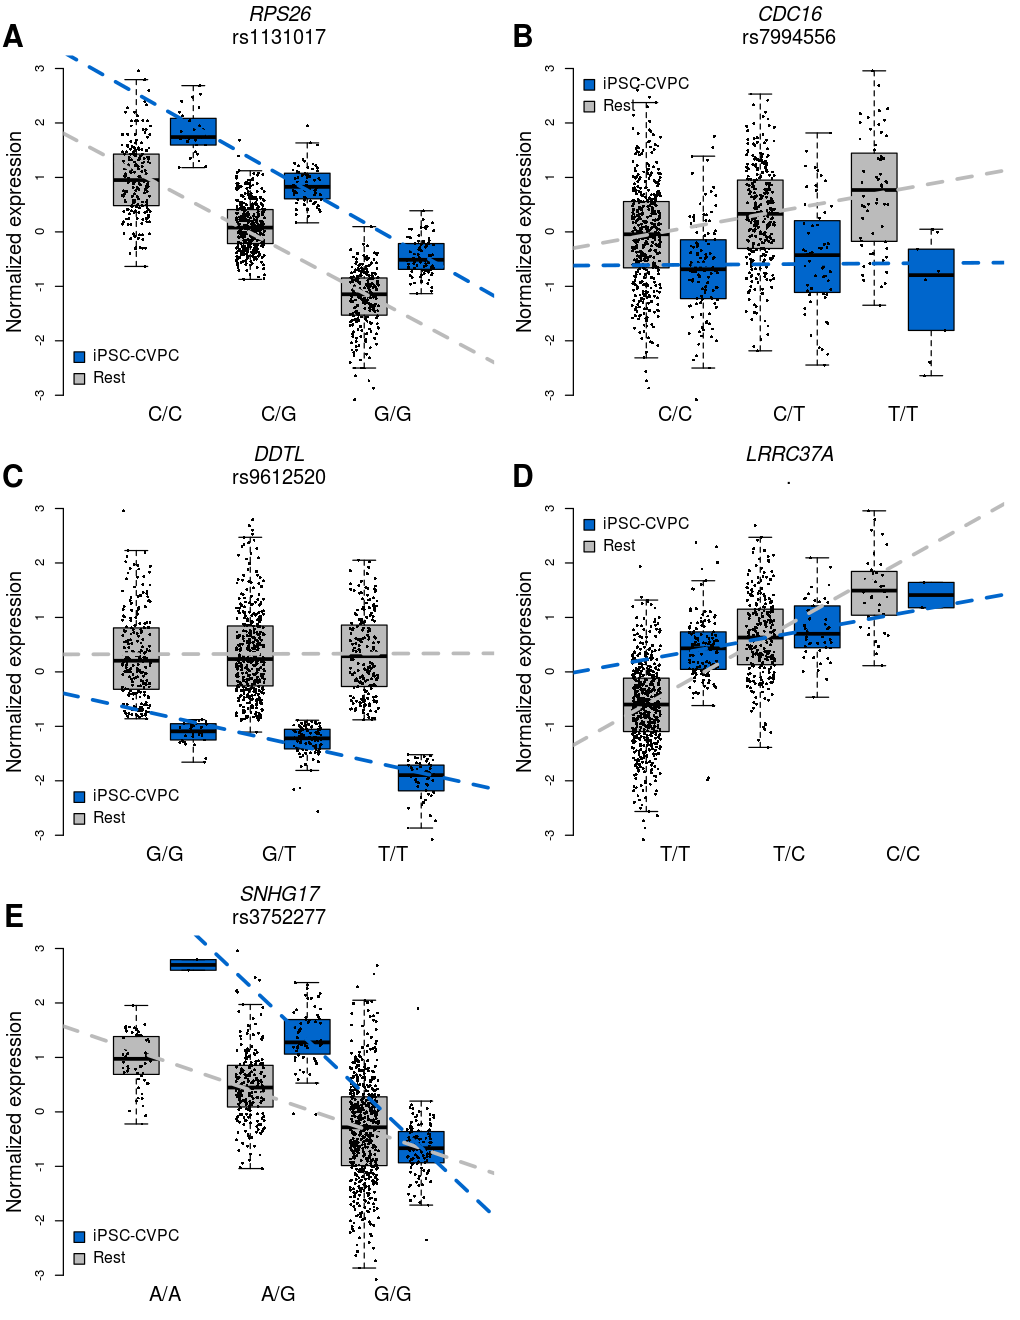

png 
  2

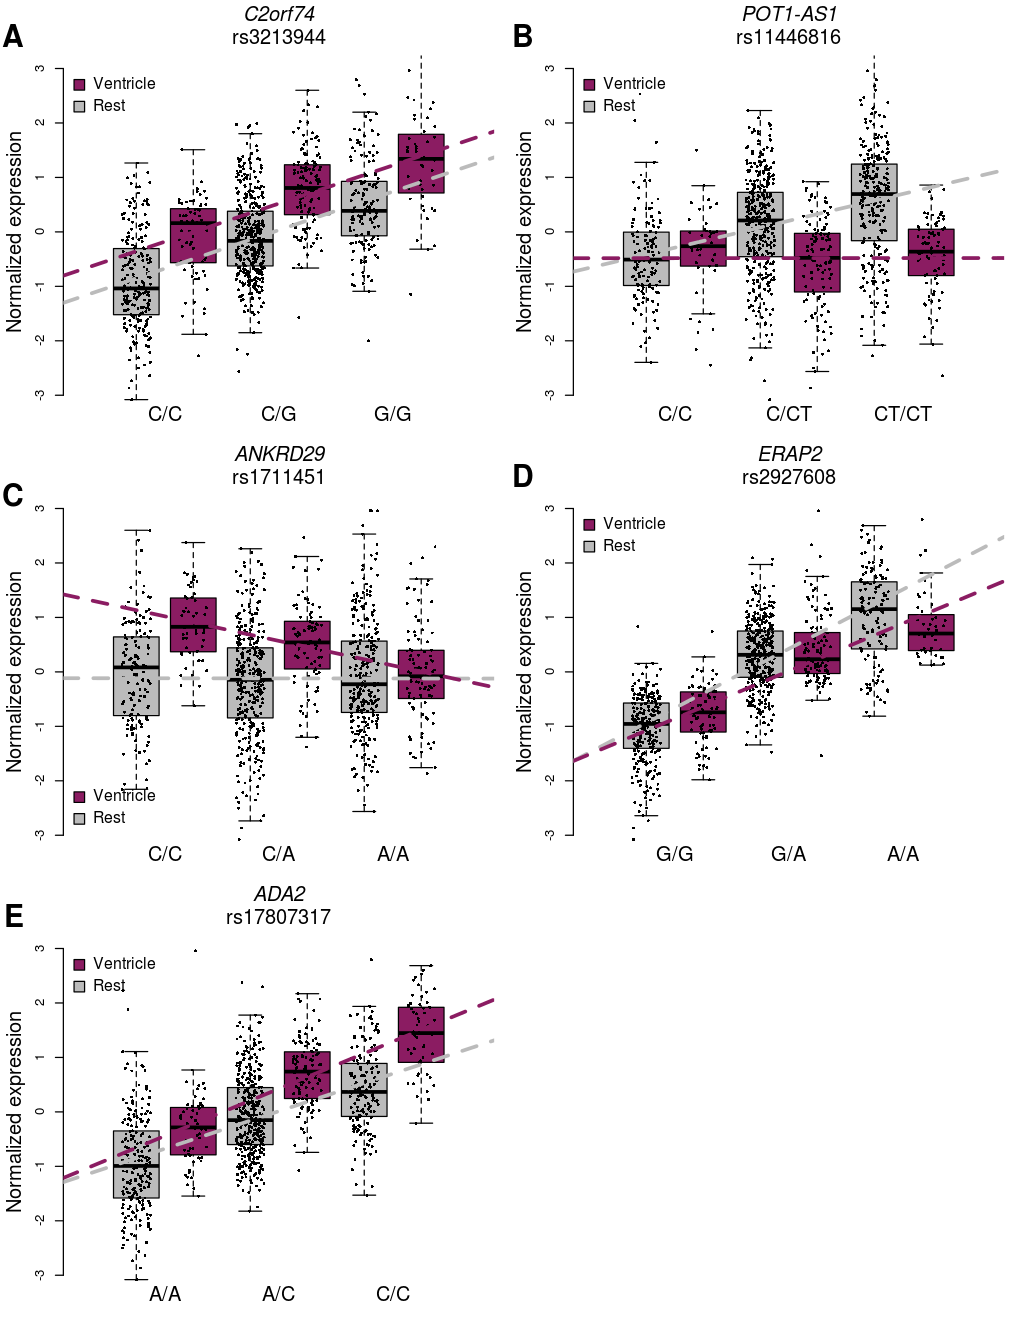

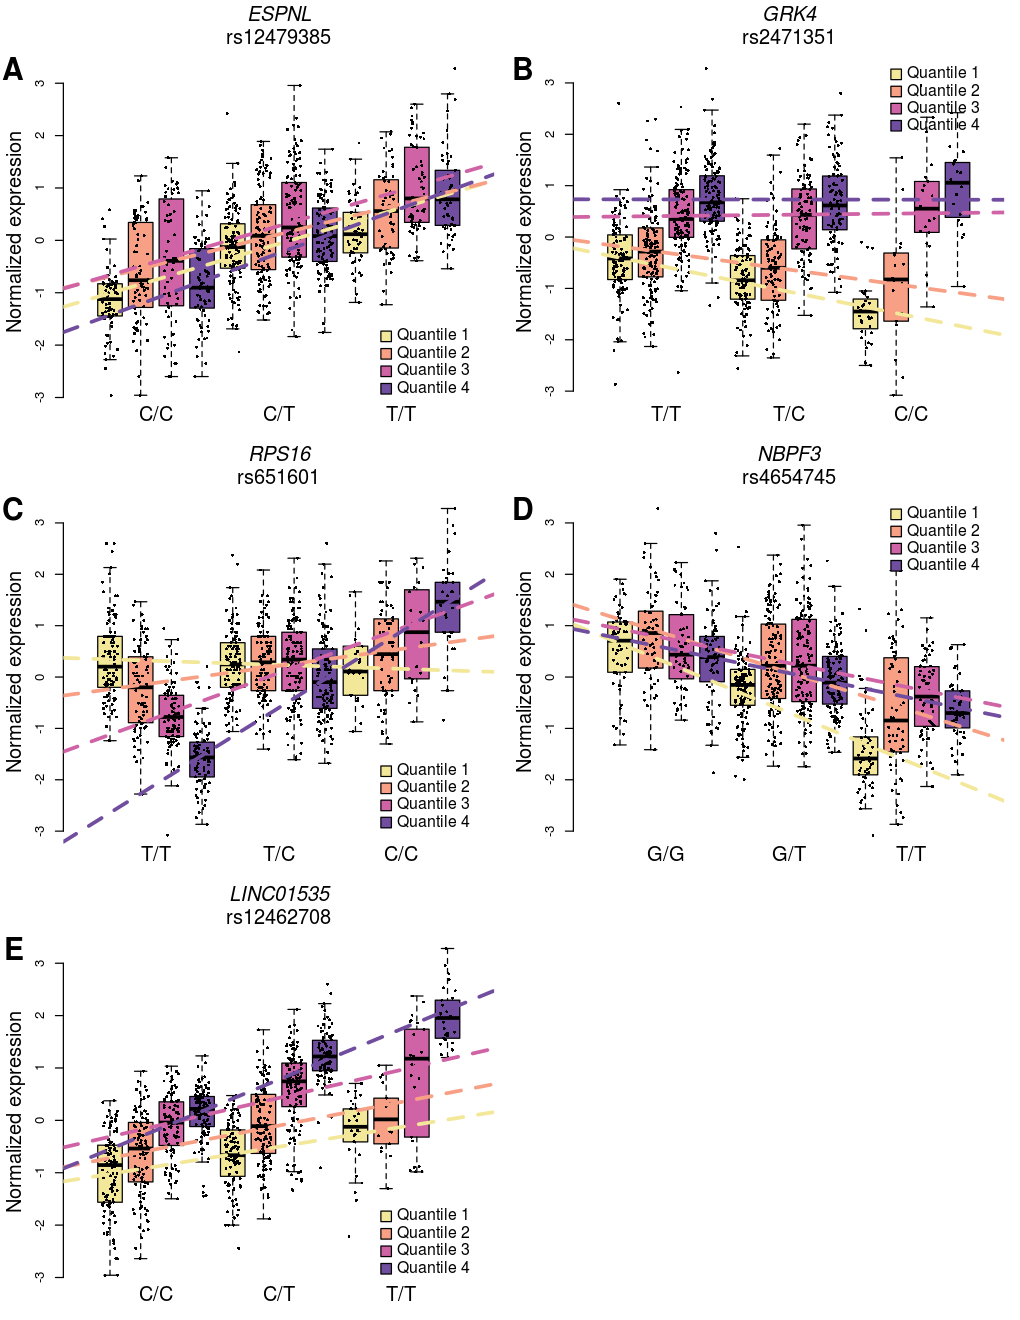

In [46]:
plot_celltype_binary = function(transcript_id, source, id, cell, colordata, legend = FALSE, panel = "")
{
    if(source == "tpm_gene"){phenotype = "rna"}
    
    gtdata      = add_rownames(fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype"  , source, paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo      =              fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype"  , source, paste("gt_info", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata      = data.frame(wgs_id = colnames(gtdata), gt = as.numeric(gtdata[id,]))
    expdata     = exp_data[["expression"]][[phenotype]][["normalized"]][transcript_id,]
    expdata     = data.frame(run = colnames(expdata), norm = as.numeric(expdata[1,]))
    toplot      = merge(exp_data$covariates, exp_data$metadata[,c("run", "wgs_id", "phenotype")], by = "run")
    toplot      = toplot[toplot$phenotype == "rna",]
    toplot      = merge(toplot, expdata, by = "run")
    toplot      = merge(toplot, gtdata , by = "wgs_id"   )
    gtinfo      = gtinfo[gtinfo$id == id,]
    eqtls       = qtl_data[["qtl"]][[phenotype]]
    toplot$cell = toplot[,cell]
    toplot$x    = (toplot$gt * 4 + 1) + toplot$cell
    
    par(mar = c(2,4,3.5,1))
    #plot(1,1, type = "n", xlim = c(0,7), ylim = range(toplot$norm), axes = FALSE, xlab = "", ylab = "")
    plot(1,1, type = "n", xlim = c(0,7), ylim = c(-3,3), axes = FALSE, xlab = "", ylab = "")
    axis(2)
    
    mycolors = c("#bbbbbb", colordata[cell, "color"])
    
    boxplot(norm ~ cell + gt, data = toplot, outline = FALSE, col = rep(mycolors, 3), add = TRUE, at = (1:6), axes = FALSE)
    points (x = jitter(toplot$x, amount = 0.25), y = toplot$norm, pch = 16, cex = 0.5)
    abline (lm(norm ~ x, data = toplot[toplot$cell == 0,]), lty = "dashed", col = mycolors[[1]], lwd = 3)
    abline (lm(norm ~ x, data = toplot[toplot$cell == 1,]), lty = "dashed", col = mycolors[[2]], lwd = 3)
    
    gt1  = gtinfo[1, "ref" ]
    gt2  = gtinfo[1, "alt" ]
    rsid = gtinfo[1, "rsid"]
    gene = unique(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "gene_name"])
    gts  = c(paste(gt1, gt1, sep = "/"), paste(gt1, gt2, sep = "/"), paste(gt2, gt2, sep = "/"))
    
    mtext(gts                    , side = 1, line =  0  , at = c(1.5, 3.5, 5.5))
    mtext(gene                   , side = 3, line =  2  , font = 3)
    mtext(rsid                   , side = 3, line =  0.5)
    mtext("Normalized expression", side = 2, line =  2.5)
    mtext(text = panel           , side = 2, line =  2.5, las = 2, at = max(toplot$norm) * 1.1, font = 2, cex = 1.5)
    
    if(legend == TRUE)
    {
        myoffset = 0
        if(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "beta"] > 0){myoffset = 5}
        points(x = rep(0  , 2), y = c(-2.7, -2.3) + myoffset, pch = 22, bg = mycolors, cex = 2)
        text  (x = rep(0.1, 2), y = c(-2.7, -2.3) + myoffset, labels = c("Rest", colordata[cell, "tissue"]), pos = 4, cex = 1.2)
    }
}

plot_celltype_quantile = function(transcript_id, source, id, cell, colordata, legend = FALSE, panel = "", quantiles = 4)
{
    if(source == "tpm_gene"){phenotype = "rna"}
    
    gtdata   = add_rownames(fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype"  , source, paste("gt_data", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE))
    gtinfo   =              fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype"  , source, paste("gt_info", transcript_id, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE , data.table = FALSE)
    gtdata   = data.frame(wgs_id = colnames(gtdata), gt = as.numeric(gtdata[id,]))
    expdata  = exp_data[["expression"]][[phenotype]][["normalized"]][transcript_id,]
    expdata  = data.frame(run = colnames(expdata), norm = as.numeric(expdata[1,]))
    toplot   = merge(exp_data$covariates, exp_data$metadata[,c("run", "wgs_id", "phenotype")], by = "run")
    toplot   = toplot[toplot$phenotype == "rna",]
    toplot   = merge(toplot, expdata, by = "run")
    toplot   = merge(toplot, gtdata , by = "wgs_id"   )
    gtinfo   = gtinfo[gtinfo$id == id,]
    eqtls    = qtl_data[["qtl"]][[phenotype]]
    
    toplot$cell     = toplot[,cell]
    toplot          = toplot[order(toplot$cell),]
    quantiles       = round((1:quantiles) / quantiles * nrow(toplot), digits = 0)
    toplot$quantile = 0
    
    for(ii in 1:length(quantiles))
    {
        x1 = quantiles[[ii]]
        x0 = 1
        if (ii > 1){x0 = quantiles[[ii - 1]] + 1}
        
        toplot[x0:x1, "quantile"] = ii
    }
    
    toplot$gt_quantile = paste(toplot$gt, toplot$quantile)
    tobox              = aggregate(norm ~ quantile + gt + gt_quantile, data = toplot, mean)
    tobox              = tobox[order(tobox$gt, tobox$quantile),]
    tobox$x            = 1:nrow(tobox)
    toplot             = merge(toplot, tobox[,c("gt_quantile", "x")])
    quantile2color     = data.frame(quantile = sort(unique(toplot$quantile)), color = sequential_hcl(n = length(unique(toplot$quantile)), palette = "Sunset", rev = TRUE))
    
    par(mar = c(2,4,3.5,1))
    plot(1,1, type = "n", xlim = c(0,max(toplot$x + 1)), ylim = range(toplot$norm), axes = FALSE, xlab = "", ylab = "")
    axis(2)
    
    boxplot(norm ~ quantile + gt, data = toplot, outline = FALSE, col = rep(quantile2color$color, 3), add = TRUE, at = tobox$x, axes = FALSE)
    points (x = jitter(toplot$x, amount = 0.25), y = toplot$norm, pch = 16, cex = 0.5)
    
    invisible(lapply(1:nrow(quantile2color), function(ii)
    {
        this = toplot[toplot$quantile == quantile2color[ii, "quantile"],]
        
        abline (lm(norm ~ x, data = this), lty = "dashed", col = quantile2color[ii, "color"], lwd = 3)
    }))
    
    gt1       = gtinfo[1, "ref" ]
    gt2       = gtinfo[1, "alt" ]
    rsid      = gtinfo[1, "rsid"]
    this_eqtl = eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, ]
    gene      = unique(this_eqtl[, "gene_name"])
    gts       = c(paste(gt1, gt1, sep = "/"), paste(gt1, gt2, sep = "/"), paste(gt2, gt2, sep = "/"))
    
    mtext(gts                    , side = 1, line =  0  , at = aggregate(x ~ gt, data = tobox, FUN = mean)$x)
    mtext(gene                   , side = 3, line =  2  , font = 3)
    mtext(rsid                   , side = 3, line =  0.5)
    #mtext(cell                   , side = 3, line = -1  )
    mtext("Normalized expression", side = 2, line =  2.5)
    mtext(text = panel           , side = 2, line =  2.5, las = 2, at = max(toplot$norm), font = 2, cex = 1.5)

    if(legend == TRUE)
    {
        myoffset = 0
        if(eqtls[eqtls$transcript_id == transcript_id & eqtls$id == id, "beta"] < 0){myoffset = 5}
        points(x = rep(10  , nrow(quantile2color)), y = -((1:nrow(quantile2color)) / 3) - 1.5 + myoffset, pch = 22, bg = quantile2color$color, cex = 2)
        text  (x = rep(10.1, nrow(quantile2color)), y = -((1:nrow(quantile2color)) / 3) - 1.5 + myoffset, labels = paste("Quantile", quantile2color$quantile), pos = 4, cex = 1.2)
    }
}

figure_s2 = function(size_x = 8.5, size_y = 11,to_png = FALSE)
{
    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_S2.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
    
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    
    plot_celltype_binary ("ENSG00000197728.11_7", "tpm_gene", "VAR_12_56435929_C_G" , "ipsc_cvpc", add_rownames(exp_data$color$by_tissue), TRUE, "A")
    plot_celltype_binary ("ENSG00000130177.16_5", "tpm_gene", "VAR_13_114998076_C_T", "ipsc_cvpc", add_rownames(exp_data$color$by_tissue), TRUE, "B")
    plot_celltype_binary ("ENSG00000099974.8_5" , "tpm_gene", "VAR_22_24269459_G_T" , "ipsc_cvpc", add_rownames(exp_data$color$by_tissue), TRUE, "C")
    plot_celltype_binary ("ENSG00000176681.14_3", "tpm_gene", "VAR_17_44331214_T_C" , "ipsc_cvpc", add_rownames(exp_data$color$by_tissue), TRUE, "D")
    plot_celltype_binary ("ENSG00000196756.13_9", "tpm_gene", "VAR_20_37050753_A_G" , "ipsc_cvpc", add_rownames(exp_data$color$by_tissue), TRUE, "E")
    
    if(to_png == TRUE ){dev.off()}
}

figure_s3 = function(size_x = 8.5, size_y = 11,to_png = FALSE)
{
    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_S3.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
    
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    
    plot_celltype_binary ("ENSG00000237651.6_5"  , "tpm_gene", "VAR_2_61372298_C_G"  , "heart_ventricle",  add_rownames(exp_data$color$by_tissue), TRUE, "A")
    plot_celltype_binary ("ENSG00000224897.8_9"  , "tpm_gene", "VAR_7_124647458_C_CT", "heart_ventricle",  add_rownames(exp_data$color$by_tissue), TRUE, "B")
    plot_celltype_binary ("ENSG00000154065.17_5" , "tpm_gene", "VAR_18_21270434_C_A" , "heart_ventricle",  add_rownames(exp_data$color$by_tissue), TRUE, "C")
    plot_celltype_binary ("ENSG00000164308.17_9" , "tpm_gene", "VAR_5_96252432_G_A"  , "heart_ventricle",  add_rownames(exp_data$color$by_tissue), TRUE, "D")
    plot_celltype_binary ("ENSG00000093072.18_11", "tpm_gene", "VAR_22_17680519_A_C" , "heart_ventricle",  add_rownames(exp_data$color$by_tissue), TRUE, "E")

    if(to_png == TRUE ){dev.off()}
}

figure_s4 = function(size_x = 8.5, size_y = 11,to_png = FALSE)
{
    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_S4.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
    
    layout(matrix(1:6, nrow = 3, byrow = TRUE))
    
    plot_celltype_quantile("ENSG00000144488.15_4", "tpm_gene", "VAR_2_239035853_C_T", "cibersort.regular.cardiac_muscle", add_rownames(exp_data$color$by_tissue), TRUE, "A")
    plot_celltype_quantile("ENSG00000125388.20_7", "tpm_gene", "VAR_4_2984903_T_C"  , "cibersort.regular.cardiac_muscle", add_rownames(exp_data$color$by_tissue), TRUE, "B")
    plot_celltype_quantile("ENSG00000105193.9_5" , "tpm_gene", "VAR_19_39926825_T_C", "cibersort.regular.cardiac_muscle", add_rownames(exp_data$color$by_tissue), TRUE, "C")
    plot_celltype_quantile("ENSG00000142794.18_4", "tpm_gene", "VAR_1_21767096_G_T" , "cibersort.regular.cardiac_muscle", add_rownames(exp_data$color$by_tissue), TRUE, "D")
    plot_celltype_quantile("ENSG00000226686.8_6" , "tpm_gene", "VAR_19_37797578_C_T", "cibersort.regular.cardiac_muscle", add_rownames(exp_data$color$by_tissue), TRUE, "E")
    
    if(to_png == TRUE ){dev.off()}
}

figure_s2(to_png = FALSE)
figure_s2(to_png = TRUE )

figure_s3(to_png = FALSE)
figure_s3(to_png = TRUE )

figure_s4(to_png = FALSE)
figure_s4(to_png = TRUE )


## Figure 3: eQTLs

png 
  2

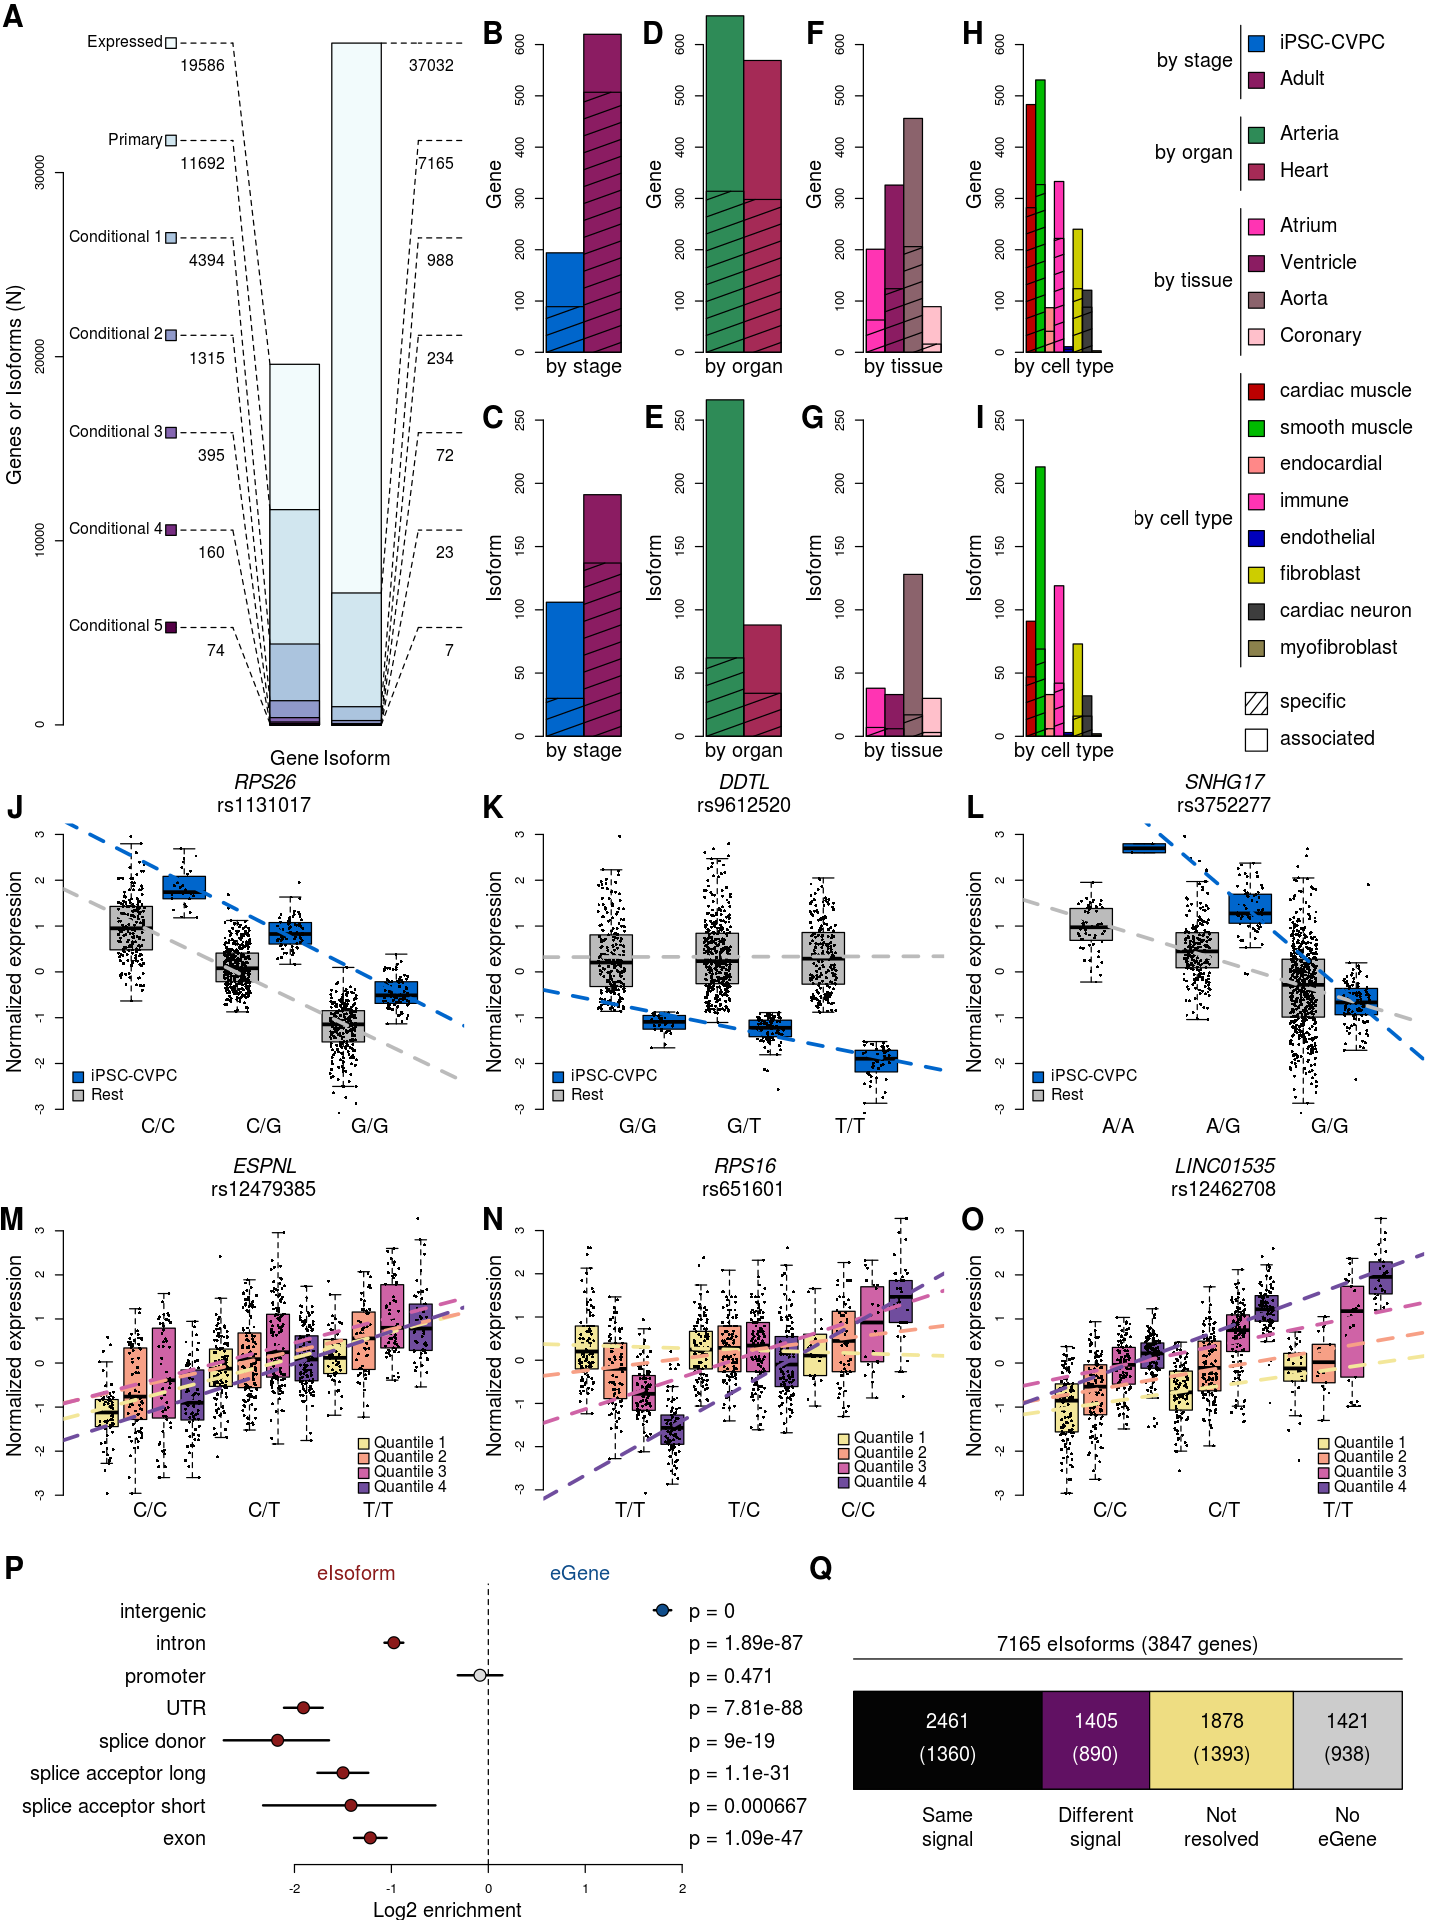

In [47]:
figure_barplot_eqtls = function()
{
    toplot    = qtl2type[c("rna", "isoform"),]
    mycols    = data.frame(x = c("Expressed", "Primary", paste("Conditional", 1:5)), x0 = 0, color = sequential_hcl(n = 7, palette = "BuPu", rev = TRUE))
    mycols$y1 = max(toplot$Expressed) * ((nrow(mycols)    ):1       ) / nrow(mycols)
    mycols$y0 = max(toplot$Expressed) * ((nrow(mycols) - 1):0       ) / nrow(mycols)
    mycols$y2 = max(toplot$Expressed) * ((nrow(mycols) - 1):0 + 0.75) / nrow(mycols)
    
    par(mar = c(1,4,1,1))
    plot(1,1, type = "n", ylim = c(0, max(toplot$Expressed)), xlim = c(-3, 3), xlab = "", ylab = "", axes = FALSE)
    mtext(text = "Genes or Isoforms (N)", side  = 2, line  = 2.5)
    axis(2)
    
    mtext(text = c("Gene", "Isoform"), side = 1, line = 0, las = 1, at = c(0.5, 1.5))
    mtext(text = "A"                 , side = 2, line = 2.5, las = 2, at = max(toplot$Expressed) * 1.04, font = 2, cex = 1.5)
    
    for(ii in 1:nrow(toplot))
    {
        rect(xleft = ii - 0.9, xright = ii - 0.1, ybottom = 0, ytop = as.numeric(toplot[ii, mycols$x]), col = mycols$color)
    }
    
    text  (x = -1.5, y = mycols$y1, labels = mycols$x                       , pos = 2, cex = 1.2)
    text  (x = -0.5, y = mycols$y2, labels = as.numeric(toplot[1, mycols$x]), pos = 2, cex = 1.2)
    text  (x =  3.2, y = mycols$y2, labels = as.numeric(toplot[2, mycols$x]), pos = 2, cex = 1.2)
    
    segments(x0 =  0.1, x1 = -0.5, y0 = as.numeric(toplot[1, mycols$x]), y1 = mycols$y1, lty = "dashed")
    segments(x0 =  1.9, x1 =  2.5, y0 = as.numeric(toplot[2, mycols$x]), y1 = mycols$y1, lty = "dashed")
    segments(x0 = -1.5, x1 = -0.5, y0 = mycols$y1                      , y1 = mycols$y1, lty = "dashed")
    segments(x0 =  3.2, x1 =  2.5, y0 = mycols$y1                      , y1 = mycols$y1, lty = "dashed")
    
    points(x =  rep(-1.5, nrow(mycols)), y = mycols$y1, cex = 2, pch = 22, bg = mycols$color)
}

plot_annot_enrichment = function(x, tissue, phenotypes, annots, null_data, qtl_data, coldata, panel = "", is_top = FALSE)
{
    phenotypes$lty = 1:nrow(phenotypes) + 1
    mybreaks       = c(0, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1)
    
    if(is_top == TRUE ){mymar = 1}
    if(is_top == FALSE){mymar = 4}
    
    myy = as.numeric(unlist(x))
    myy = myy[is.na(myy) == FALSE]
    
    par(mar = c(mymar, 4,1,1))
    plot(1,1, type = "n", xlim = c(1, nrow(x[[1]])), ylim = range(myy), xlab = "", ylab = "", axes = FALSE)
    mtext(text = panel       , side = 2, line = 2.5, las = 2, at = max(myy), font = 2, cex = 1.5)
    mtext(text = "log2 ratio", side = 2, line = 2.5)
    
    abline(h = 0, lty = "dashed")
    
    if(is_top == FALSE){axis(1, at = 1:nrow(x[[1]]), labels = rownames(x[[1]]), las = 2)}
    
    axis(2)
    
    invisible(lapply(phenotypes$phenotype, function(phenotype)
    {
        lty  = phenotypes[phenotype, "lty"]
        this = x[[phenotype]]
        
        for(ii in 1:nrow(coldata))
        {
            state = coldata[ii, "state"]
            color = coldata[ii, "color"]
            
            if(color == "white"){color = "#000000"}
            
            points(x = 1:nrow(this), y = this[,state], col = color, pch = 16 )
            lines (x = 1:nrow(this), y = this[,state], col = color, lty = lty, lwd = 2)
        }
    }))
    
    mymar = 1
    par(mar = c(mymar, 0,1,0))
    plot(1,1, type = "n", xlim = c(0,1), ylim = c(nrow(coldata) + nrow(phenotypes) + 1, 0), axes = FALSE)
    
    segments(x0 = 0, x1 = 0.1, y0 =  1:nrow(phenotypes)                    , lty    = phenotypes$lty        , lwd = 2, col = "#000000"    )
    segments(x0 = 0, x1 = 0.1, y0 = (1:nrow(coldata   )) + nrow(phenotypes), lty    = "solid"               , lwd = 2, col = coldata$color)
    text    (        x  = 0.1, y  =  1:nrow(phenotypes)                    , labels = phenotypes$name       , pos = 4, cex = 1.2)
    text    (        x  = 0.1, y  = (1:nrow(coldata   )) + nrow(phenotypes), labels = coldata   $description, pos = 4, cex = 1.1)
}

plot_qtl_cell = function(phenotype, qtl2cell_all, qtl2cell_specific, colordata, phenotypes, panels = c("", "", ""))
{
    par(mar = c(2,4,1,1))
    
    names(panels) = names(colordata)
    
    invisible(lapply(names(colordata), function(x)
    {
        this = colordata[[x]]
        name = gsub("cell", "cell type", gsub("_", " ", x))
        
        #if(x == "by_cell"){this$body_site = this$cell_type}
        
        ylims = max(as.numeric(qtl2cell_all[ qtl2cell_all$phenotype == phenotype, grepl("^by_", colnames(qtl2cell_all)) == TRUE]))
        
        toplot_all      = as.numeric(qtl2cell_all     [ qtl2cell_all     $phenotype == phenotype, paste(x, this$body_site, sep = ":")])
        toplot_specific = as.numeric(qtl2cell_specific[ qtl2cell_specific$phenotype == phenotype, paste(x, this$body_site, sep = ":")])

        barplot(toplot_all                        , width = 1, space = 0, ylab = "", ylim = c(0, ylims), col = this$color)
        barplot(toplot_specific                   , width = 1, space = 0, ylab = "", axes = FALSE, density = 30, add = TRUE, col = "#000000")
        mtext(text = phenotypes[phenotype, "name"], side  = 2, line  = 2.5)
        mtext(text = name                         , side  = 1, line  = 0.5)
        mtext(text = panels[[x]]                  , side  = 2, line  = 2.5, las = 2, at = ylims * 0.95, font = 2, cex = 1.5)
    }))
    
    if(phenotype == "chip")
    {
        par(mar = c(1,4,0,1))
        invisible(lapply(names(colordata), function(x)
        {
            this       = colordata[[x]]

            if(x == "by_cell"){this$body_site = this$cell_type}
            if(x == "by_cell"){this$tissue    = this$name     }

            toplot_all = as.numeric(qtl2cell_all[ qtl2cell_all$phenotype == phenotype, paste(x, this$body_site, sep = ":")])


            barplot(toplot_all     , width = 1, space = 0, ylab = "", col = this$color, ylim = c(-20, -10), axes = FALSE)
            text(x = 1:length(toplot_all) - 0.5, y = -11, labels = this$tissue, srt = 90, pos = 2, cex = 1.5)
        }))
    }
}

plot_legend_cells = function(colordata)
{
    colordata$by_organ $order  = colordata$by_organ $order + 0.5 + max(colordata$by_stage $order)
    colordata$by_tissue$order  = colordata$by_tissue$order + 0.5 + max(colordata$by_organ $order)
    colordata$by_cell  $order  = colordata$by_cell  $order + 0.5 + max(colordata$by_tissue$order)
    
    toplot = rbind(colordata[["by_stage" ]][,c("name", "color", "order")],
                   colordata[["by_organ" ]][,c("name", "color", "order")],
                   colordata[["by_tissue"]][,c("name", "color", "order")],
                   colordata[["by_cell"  ]][,c("name", "color", "order")]
                  )
    
    par(mar = c(0,1,1,1))
    plot(1,1, type = "n", xlim = c(-0.7,1), ylim = c(max(toplot$order) + 2.5, 1), axes = FALSE)
    
    points(x = rep(0  , nrow(toplot)), y = toplot$order, bg     = toplot$color , pch = 22, cex = 3)
    text  (x = rep(0.1, nrow(toplot)), y = toplot$order, labels = toplot$name  , pos =  4, cex = 1.5)
    
    segments(x0 = -0.1, y0 = unlist(lapply(colordata, function(x){min(x$order)})) - 0.5, y1 = unlist(lapply(colordata, function(x){max(x$order)})) + 0.5)
    text    (x  = -0.1, y  = unlist(lapply(colordata, function(x){min(x$order) + (max(x$order) - min(x$order)) / 2})), labels = gsub("cell", "cell type", gsub("_", " ", names(colordata))), pos = 2, cex = 1.5)
    
    text(x = rep(0.1, 2), y = max(toplot$order) + c(1.5, 2.5), labels = c("specific", "associated"), pos = 4, cex = 1.5)
    
    rect(xleft = -0.07, xright = 0.07, ybottom = max(toplot$order) + c(1.8, 2.8), ytop = max(toplot$order) + c(1.2, 2.2), density = c(30, 0))
}

plot_cartoon_gene = function(panel = "")
{
    par(mar = c(1,1,1,1))
    plot(1,1, type = "n", xlim = c(-20,120), ylim = c(-20,100), xlab = "", ylab = "", axes = FALSE)
    
    toplot = test_overlap$test
    
    # main
    rect(xleft = -20, xright = 120, ybottom = 0, ytop = 20, col = toplot["outside"              , "color"])
    rect(xleft =   0, xright = 100, ybottom = 0, ytop = 20, col = toplot["intron"               , "color"])
    rect(xleft =   0, xright =  10, ybottom = 0, ytop = 20, col = toplot["promoter"             , "color"])
    rect(xleft =  10, xright =  20, ybottom = 0, ytop = 20, col = toplot["exon"                 , "color"])
    rect(xleft =  40, xright =  60, ybottom = 0, ytop = 20, col = toplot["exon"                 , "color"])
    rect(xleft =  39, xright =  42, ybottom = 0, ytop = 20, col = toplot["splice_acceptor_short", "color"])
    rect(xleft =  35, xright =  39, ybottom = 0, ytop = 20, col = toplot["splice_acceptor_long" , "color"])
    rect(xleft =  60, xright =  63, ybottom = 0, ytop = 20, col = toplot["splice_donor"         , "color"])
    rect(xleft =  80, xright =  90, ybottom = 0, ytop = 20, col = toplot["exon"                 , "color"])
    rect(xleft =  90, xright = 100, ybottom = 0, ytop = 20, col = toplot["UTR"                  , "color"])
    
    # splice donor
    rect(xleft =  90, xright = 110, ybottom = 40, ytop = 60, col = toplot["intron"      , "color"])
    rect(xleft =  80, xright =  90, ybottom = 40, ytop = 60, col = toplot["splice_donor", "color"])
    rect(xleft =  70, xright =  80, ybottom = 40, ytop = 60, col = toplot["exon"        , "color"])
    
    #splice acceptor
    rect(xleft = -10, xright =  60, ybottom = 60, ytop = 80, col = toplot["intron"               , "color"])
    rect(xleft =  10, xright =  40, ybottom = 60, ytop = 80, col = toplot["splice_acceptor_long" , "color"])
    rect(xleft =  40, xright =  50, ybottom = 60, ytop = 80, col = toplot["splice_acceptor_short", "color"])
    rect(xleft =  50, xright =  60, ybottom = 60, ytop = 80, col = toplot["exon"                 , "color"])
    
    # links
    segments(x0 = 30, x1 = -10, y0 = 20, y1 = 60, lty = "dashed")
    segments(x0 = 45, x1 =  60, y0 = 20, y1 = 60, lty = "dashed")
    segments(x0 = 55, x1 =  70, y0 = 20, y1 = 40, lty = "dashed")
    segments(x0 = 70, x1 = 110, y0 = 20, y1 = 40, lty = "dashed")
    
    rect(xleft =  30, xright =  45, ybottom = 0, ytop = 20, col = NA, lty = "dashed")
    rect(xleft =  55, xright =  70, ybottom = 0, ytop = 20, col = NA, lty = "dashed")
    
    # text
    text(x = -10, y = -10, cex = 1.2, labels = "outside" , srt = 45)
    text(x =   0, y = -10, cex = 1.2, labels = "Promoter", srt = 45)
    text(x =  12, y = -10, cex = 1.2, labels = "Exon"    , srt = 45)
    text(x =  25, y = -10, cex = 1.2, labels = "Intron"  , srt = 45)
    text(x =  92, y = -10, cex = 1.2, labels = "UTR"     , srt = 45)
    text(x =  90, y =  60, cex = 1.2, labels = "Splice donor (0-10 bp)", pos = 3)
    text(x =  30, y =  80, cex = 1.2, labels = "Splice acceptor"       , pos = 3)
    text(x =  48, y =  60, cex = 1.2, labels = "(0-5 bp)"              , pos = 1)
    text(x =  22, y =  60, cex = 1.2, labels = "(6-100 bp)"            , pos = 1)

    mtext(text = panel, side = 2, line = -1, las = 2, at = 90, font = 2, cex = 1.5)
}

plot_bar_enrichment = function(panel = "")
{
    toplot = test_overlap$test
    
    par(mar = c(4,6,1,1))
    yy = barplot(as.matrix(toplot[,c("rna_per", "isoform_per")]), names.arg = c("", ""), horiz = TRUE, col = toplot$color, xlab = "", ylab = "", axes = FALSE, width = 1, space = 0.2, ylim = c(2.4, 0))
    axis(1)
    
    mtext(text = "eQTLs (%)"         , side = 1, line = 2.5)
    mtext(text = c("Gene", "Isoform"), side = 2, line = 1  , las = 2, at = yy)
    mtext(text = panel               , side = 2, line = 4.5, las = 2, at = 0 , font = 2, cex = 1.5)
}

plot_enrichment_gene_vs_iso = function()
{
    toplot            = test_overlap$test
    toplot$log2_est   = log2(toplot$estimate)
    toplot$log2_ci1   = log2(toplot$ci1     )
    toplot$log2_ci2   = log2(toplot$ci2     )
    toplot$order      = 1:nrow(toplot)
    #toplot$annotation = gsub("acceptor", "acceptor\n", gsub("_", " ", toplot$annotation))
    toplot$annotation = gsub("outside", "intergenic", gsub("_", " ", toplot$annotation))
    col1              = "#104E8B"
    col2              = "#8B1A1A"
    toplot$color      = "#dddddd"
    toplot$ptext      = paste0("p = ", signif(toplot$pval, digits = 3))
    
    toplot[toplot$pval < 0.05 & toplot$log2_est > 0, "color"] = col1
    toplot[toplot$pval < 0.05 & toplot$log2_est < 0, "color"] = col2
    
    par(mar = c(3.5, 13, 3, 7))
    plot(1,1, type = "n", xlim = range(as.numeric(as.matrix(toplot[,c("log2_ci1", "log2_ci2")]))), ylim = c(nrow(toplot), 0), xlab = "", ylab = "", axes = FALSE)
    axis(1)
    mtext(text = "Log2 enrichment"     , side = 1, line =  2.5, las = 1)
    mtext(text = "P"                   , side = 2, line = 11.5, las = 2, at = -(nrow(toplot)/10), font = 2, cex = 1.5)
    mtext(text = toplot$annotation     , side = 2, line =  0  , las = 2, at = toplot$order - 0.5)
    mtext(text = toplot$ptext          , side = 4, line =  0  , las = 2, at = toplot$order - 0.5)
    mtext(text = c("eGene", "eIsoform"), side = 3, line =  0  , las = 1, at = c(max(toplot$log2_ci2), min(toplot$log2_ci1)) / 2, col = c(col1, col2))
    
    abline(v = 0, lty = "dashed")
    
    segments(x0 = toplot$log2_ci1, x1 = toplot$log2_ci2, y0 = toplot$order - 0.5, lwd = 2)
    points  (x  = toplot$log2_est,                       y  = toplot$order - 0.5, cex = 2, pch = 21, bg = toplot$color)
}

plot_coloc_isoform_vs_gene_bar = function()
{
    par(mar = c(3.5, 2, 3, 1))
    plot(1,1, type = "n", xlim = c(0, overlap_eqtls["eIsoforms", "eisoforms"]), ylim = c(0.3, 1.1), xlab = "", ylab = "", axes = FALSE)
    
    rect(xleft = overlap_eqtls$from, xright = overlap_eqtls$to, ybottom = 0.5, ytop = 0.8, col = overlap_eqtls$color)
    
    segments(x0 = 0, x1 = overlap_eqtls["eIsoforms"            , "eisoforms"], y0 = 0.9)
    
    text(x = overlap_eqtls["eIsoforms", "eisoforms"] / 2, y = 0.9, labels = paste0(overlap_eqtls["eIsoforms", "eisoforms"], " eIsoforms (", overlap_eqtls["eIsoforms", "egenes"], " genes)"), pos = 3, cex = 1.5)
    
    totext               = overlap_eqtls[3:6,]
    totext$color_text    = c(rep("#ffffff", 2), rep("#000000", 2))
    totext$x             = rowMeans(totext[,c("from", "to")])
    totext$label         = totext$name
    totext[1:3, "label"] = c("Same signal", "Different signal", "Not resolved")
    totext$label         = gsub(" ", "\n", totext$label)
    
    #totext[1, "eisoforms"] = paste(totext[1, "eisoforms"], "eIsoforms")
    #totext[1, "egenes"   ] = paste(totext[1, "egenes"   ], "genes"    )
    
    text(x = totext$x, y = 0.45, labels = totext$label                   , cex = 1.5, pos = 1)
    text(x = totext$x, y = 0.75, labels = totext$eisoforms               , cex = 1.5, pos = 1, col = totext$color_text)
    text(x = totext$x, y = 0.65, labels = paste0("(", totext$egenes, ")"), cex = 1.5, pos = 1, col = totext$color_text)

    mtext(text = "Q", side = 2, line = 0, las = 2, at = 1.18, font = 2, cex = 1.5)
}

figure_3 = function(size_x = 12, size_y = 16,to_png = FALSE)
{
    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_3.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
    
    layout(rbind(c(1, 1, 1, 2, 3, 4, 5, 10, 10),
                 c(1, 1, 1, 6, 7, 8, 9, 10, 10),
                 sort(rep(c(11:13), 3)),
                 sort(rep(c(14:16), 3)),
                 c(rep(17,5), rep(18,4))
                ))
    figure_barplot_eqtls()
    
    plot_qtl_cell("rna"    , qtl2cell_list$all, qtl2cell_list$specific, colordata, qtl_data$phenotypes, c("B", "D", "F", "H"))
    plot_qtl_cell("isoform", qtl2cell_list$all, qtl2cell_list$specific, colordata, qtl_data$phenotypes, c("C", "E", "G", "I"))
    
    plot_legend_cells(colordata)
    
    plot_celltype_binary ("ENSG00000197728.11_7", "tpm_gene", "VAR_12_56435929_C_G" , "ipsc_cvpc", add_rownames(exp_data$color$by_tissue), TRUE, "J")
    plot_celltype_binary ("ENSG00000099974.8_5" , "tpm_gene", "VAR_22_24269459_G_T" , "ipsc_cvpc", add_rownames(exp_data$color$by_tissue), TRUE, "K")
    plot_celltype_binary ("ENSG00000196756.13_9", "tpm_gene", "VAR_20_37050753_A_G" , "ipsc_cvpc", add_rownames(exp_data$color$by_tissue), TRUE, "L")

    plot_celltype_quantile("ENSG00000144488.15_4", "tpm_gene", "VAR_2_239035853_C_T", "cibersort.regular.cardiac_muscle", add_rownames(exp_data$color$by_tissue), TRUE, "M")
    plot_celltype_quantile("ENSG00000105193.9_5" , "tpm_gene", "VAR_19_39926825_T_C", "cibersort.regular.cardiac_muscle", add_rownames(exp_data$color$by_tissue), TRUE, "N")
    plot_celltype_quantile("ENSG00000226686.8_6" , "tpm_gene", "VAR_19_37797578_C_T", "cibersort.regular.cardiac_muscle", add_rownames(exp_data$color$by_tissue), TRUE, "O")
    
    plot_enrichment_gene_vs_iso()
    
    plot_coloc_isoform_vs_gene_bar()

    if(to_png == TRUE ){dev.off()}
}

figure_3(to_png = FALSE)
figure_3(to_png = TRUE )


In [48]:
str(colordata)

List of 4
 $ by_stage :'data.frame':	2 obs. of  5 variables:
  ..$ body_site: chr [1:2] "ipsc_cvpc" "adult"
  ..$ name     : chr [1:2] "iPSC-CVPC" "Adult"
  ..$ color    : chr [1:2] "#0066CC" "#8B1C62"
  ..$ order    : int [1:2] 1 2
  ..$ type     : chr [1:2] "stage" "stage"
 $ by_organ :'data.frame':	2 obs. of  5 variables:
  ..$ body_site: chr [1:2] "arteria" "heart"
  ..$ name     : chr [1:2] "Arteria" "Heart"
  ..$ color    : chr [1:2] "#2E8B57" "#A52A56"
  ..$ order    : int [1:2] 1 2
  ..$ type     : chr [1:2] "organ" "organ"
 $ by_tissue:'data.frame':	4 obs. of  5 variables:
  ..$ body_site: chr [1:4] "heart_atrium" "heart_ventricle" "arteria_aorta" "arteria_coronary"
  ..$ name     : chr [1:4] "Atrium" "Ventricle" "Aorta" "Coronary"
  ..$ color    : chr [1:4] "#FF34B3" "#8B1C62" "#8B636C" "#FFC0CB"
  ..$ order    : int [1:4] 1 2 3 4
  ..$ type     : chr [1:4] "tissue" "tissue" "tissue" "tissue"
 $ by_cell  :'data.frame':	8 obs. of  5 variables:
  ..$ body_site: chr [1:8] "ciber

# Part 3: colocalization between GWAS and eQTLs

In [49]:
signal2qtl_n1 = aggregate(transcript_id ~ signal_id, data = coloc_eqtls[ coloc_eqtls$PP.H4.abf >= 0.8 & coloc_eqtls$phenotype == "rna"    , ], FUN = function(x){length(unique(x))})
signal2qtl_n2 = aggregate(transcript_id ~ signal_id, data = coloc_eqtls[ coloc_eqtls$PP.H4.abf >= 0.8 & coloc_eqtls$phenotype == "isoform", ], FUN = function(x){length(unique(x))})

signal2qtl_n  = merge(signal2qtl_n1, signal2qtl_n2, by = "signal_id", all = TRUE, suffixes = 1:2)
colnames(signal2qtl_n) = c("signal_id", "egenes", "eisoforms")
signal2qtl_n[is.na(signal2qtl_n$egenes   ) == TRUE, "egenes"   ] = 0
signal2qtl_n[is.na(signal2qtl_n$eisoforms) == TRUE, "eisoforms"] = 0
signal2qtl_n$n = rowSums(signal2qtl_n[,c("egenes", "eisoforms")])

#signal2qtl_n$n = as.numeric(rownames(signal2qtl_n))

In [50]:
signal2qtl = merge(locus2coloc[,c("id", "locus", "traits_n", "traits", "credible_set", "finemapped")], signal2qtl_n, by.x = "id", by.y = "signal_id", all.x = TRUE)
signal2qtl[ is.na(signal2qtl$egenes   ) == TRUE, "egenes"   ] = 0
signal2qtl[ is.na(signal2qtl$eisoforms) == TRUE, "eisoforms"] = 0
signal2qtl[ is.na(signal2qtl$n        ) == TRUE, "n"        ] = 0

signal2qtl = signal2qtl[order(signal2qtl$traits_n, decreasing = TRUE),]

In [51]:
signal2int                 = fread("pipeline/5.5.meta_analysis/gwas2cell_df.txt", sep = "\t", header = TRUE, data.table = FALSE)
signal2qtl_merge           = signal2qtl[,c("id", "egenes", "eisoforms")]
colnames(signal2qtl_merge) = c("id", "egenes_n", "eisoforms_n")
signal2int                 = merge(signal2int, signal2qtl_merge)

In [52]:
signal2qtl_multi = merge(signal2qtl[ signal2qtl$n >= 10,], manifest[,c("id", "name")], by.x = "traits", by.y = "id")

signal2qtl_multi

traits                           id                     
1 biomarkers-30600-both_sexes-irnt 7_98617923_100905508.2 
2 biomarkers-30680-both_sexes-irnt 1_153504112_156982996.5
3 biomarkers-30760-both_sexes-irnt 3_46327835_53972391.4  
4 biomarkers-30870-both_sexes-irnt 22_24141101_24503541.1 
5 continuous-102-both_sexes-irnt   16_233138_809630.2     
6 continuous-21001-both_sexes-irnt 1_965800_2544414.5     
7 continuous-21001-both_sexes-irnt 16_14277712_16384360.5 
8 continuous-21001-both_sexes-irnt 17_40144007_48070076.9 
  locus                 traits_n credible_set finemapped egenes eisoforms n 
1 7_98617923_100905508  1        225          TRUE       5      12        17
2 1_153504112_156982996 1          7          TRUE       6       5        11
3 3_46327835_53972391   1         68          TRUE       7       3        10
4 22_24141101_24503541  1         83          TRUE       9       5        14
5 16_233138_809630      1        112          TRUE       6       4        10
6 1_965800_2544414      1         10          TRUE       4       6        10
7 16_14277712_16384360  1        136          TRUE       4       9        13
8 17_40144007_48070076  1          4          TRUE       8      13        21
  name                 
1 Albumin              
2 Calcium              
3 HDL cholesterol      
4 Triglycerides        
5 Pulse rate           
6 Body mass index (BMI)
7 Body mass index (BMI)
8 Body mass index (BMI)

In [53]:
signal2qtl_multi_eqtl = merge(coloc_eqtls[coloc_eqtls$PP.H4.abf >= 0.8, c("signal_id", "transcript_id", "gene_name", "phenotype", "id", "PP.H4.abf")], signal2qtl_multi, by.x = "signal_id", by.y = "id")

lapply(sort(unique(signal2qtl_multi_eqtl$signal_id)), function(x){signal2qtl_multi_eqtl[signal2qtl_multi_eqtl$signal_id == x,]})

[[1]]
                 signal_id        transcript_id  gene_name phenotype
1  1_153504112_156982996.5 ENSG00000169418.10_4       NPR1       rna
2  1_153504112_156982996.5  ENST00000612778.4_2       MUC1   isoform
3  1_153504112_156982996.5  ENST00000620103.4_2       MUC1   isoform
4  1_153504112_156982996.5  ENST00000368677.2_1       NPR1   isoform
5  1_153504112_156982996.5  ENSG00000271853.5_8 AL162258.1       rna
6  1_153504112_156982996.5  ENSG00000272030.1_8 AL162258.2       rna
7  1_153504112_156982996.5  ENST00000368680.4_2       NPR1   isoform
8  1_153504112_156982996.5 ENSG00000189171.14_5    S100A13       rna
9  1_153504112_156982996.5 ENSG00000169231.13_5      THBS3       rna
10 1_153504112_156982996.5 ENSG00000160678.12_4     S100A1       rna
11 1_153504112_156982996.5  ENST00000392623.5_2    S100A13   isoform
                    id PP.H4.abf                           traits
1  VAR_1_153604112_G_A 0.9535745 biomarkers-30680-both_sexes-irnt
2  VAR_1_155162067_C_T 0.9938456 biomarkers-30680-both_sexes-irnt
3  VAR_1_155162067_C_T 0.9929024 biomarkers-30680-both_sexes-irnt
4  VAR_1_153632852_C_A 0.9685940 biomarkers-30680-both_sexes-irnt
5  VAR_1_153622220_G_A 0.9702537 biomarkers-30680-both_sexes-irnt
6  VAR_1_153606851_A_G 0.9647667 biomarkers-30680-both_sexes-irnt
7  VAR_1_153632852_C_A 0.9660057 biomarkers-30680-both_sexes-irnt
8  VAR_1_153623478_A_G 0.8459876 biomarkers-30680-both_sexes-irnt
9  VAR_1_155178782_A_T 0.9967833 biomarkers-30680-both_sexes-irnt
10 VAR_1_153604112_G_A 0.9078516 biomarkers-30680-both_sexes-irnt
11 VAR_1_153604112_G_A 0.9428122 biomarkers-30680-both_sexes-irnt
                   locus traits_n credible_set finemapped egenes eisoforms  n
1  1_153504112_156982996        1            7       TRUE      6         5 11
2  1_153504112_156982996        1            7       TRUE      6         5 11
3  1_153504112_156982996        1            7       TRUE      6         5 11
4  1_153504112_156982996        1            7       TRUE      6         5 11
5  1_153504112_156982996        1            7       TRUE      6         5 11
6  1_153504112_156982996        1            7       TRUE      6         5 11
7  1_153504112_156982996        1            7       TRUE      6         5 11
8  1_153504112_156982996        1            7       TRUE      6         5 11
9  1_153504112_156982996        1            7       TRUE      6         5 11
10 1_153504112_156982996        1            7       TRUE      6         5 11
11 1_153504112_156982996        1            7       TRUE      6         5 11
      name
1  Calcium
2  Calcium
3  Calcium
4  Calcium
5  Calcium
6  Calcium
7  Calcium
8  Calcium
9  Calcium
10 Calcium
11 Calcium

[[2]]
            signal_id        transcript_id  gene_name phenotype
12 1_965800_2544414.5  ENST00000617444.5_3   SLC35E2B   isoform
13 1_965800_2544414.5  ENST00000611123.1_2   SLC35E2B   isoform
14 1_965800_2544414.5  ENST00000480991.1_2   SLC35E2B   isoform
15 1_965800_2544414.5  ENST00000643905.1_2   SLC35E2A   isoform
16 1_965800_2544414.5  ENST00000490017.1_1     MMP23B   isoform
17 1_965800_2544414.5  ENST00000647043.1_2   SLC35E2A   isoform
18 1_965800_2544414.5  ENST00000611123.1_2   SLC35E2B   isoform
19 1_965800_2544414.5  ENSG00000227775.3_6 AL031282.1       rna
20 1_965800_2544414.5  ENSG00000272004.1_6 FO704657.1       rna
21 1_965800_2544414.5 ENSG00000189339.12_5   SLC35E2B       rna
22 1_965800_2544414.5  ENSG00000215790.7_7   SLC35E2A       rna
23 1_965800_2544414.5  ENSG00000227775.3_6 AL031282.1       rna
24 1_965800_2544414.5  ENSG00000227775.3_6 AL031282.1       rna
                  id PP.H4.abf                           traits
12 VAR_1_1590521_G_A 0.9889096 continuous-21001-both_sexes-irnt
13 VAR_1_1590521_G_A 0.9970101 continuous-21001-both_sexes-irnt
14 VAR_1_1596500_C_T 0.9976180 continuous-21001-both_sexes-irnt
15 VAR_1_1596500_C_T 0.9975897 continuous-21001-both_sexes-irnt
16 VAR_1_1590521_G_A 0.9940833 continuous-21001-both_sexes-irnt
17 VAR_1_1590521_G_

In [54]:
signals_overlap    = length(unique(coloc_eqtls$signal_id                                  ))
signals_coloc      = length(unique(coloc_eqtls[ coloc_eqtls$PP.H4.abf >= 0.8, "signal_id"]))

message(paste(paste0("Signals that overlap with eGenes/eIsoforms = "                , signals_overlap, " (", signif(signals_overlap / nrow(locus2coloc) * 100, digits = 3), "%)"),
              paste0("Signals that colocalize with eGenes/eIsoforms (PPH4 > 0.8) = ", signals_coloc  , " (", signif(signals_coloc   / nrow(locus2coloc) * 100, digits = 3), "%)"),
              paste0("Signals that colocalize with one eGene/eIsoform = "           , nrow(signal2qtl_n[signal2qtl_n$n == 1 , ]), " (", signif(nrow(signal2qtl_n[signal2qtl_n$n == 1 , ])   / nrow(signal2qtl_n) * 100, digits = 3), "%)"),
              paste0("Signals that colocalize with ten or more eGenes/eIsoforms = " , nrow(signal2qtl_n[signal2qtl_n$n >= 10, ]), " (", signif(nrow(signal2qtl_n[signal2qtl_n$n >= 10, ])   / nrow(signal2qtl_n) * 100, digits = 3), "%)"),
              sep = "\n"))

Signals that overlap with eGenes/eIsoforms = 2880 (84.1%)
Signals that colocalize with eGenes/eIsoforms (PPH4 > 0.8) = 722 (21.1%)
Signals that colocalize with one eGene/eIsoform = 425 (58.9%)
Signals that colocalize with ten or more eGenes/eIsoforms = 8 (1.11%)



In [55]:
aggregate(transcript_id ~ phenotype            , data = coloc_eqtls                                 , FUN = function(x){length(unique(x))})
aggregate(transcript_id ~ phenotype            , data = coloc_eqtls[ coloc_eqtls$PP.H4.abf >= 0.8, ], FUN = function(x){length(unique(x))})


phenotype transcript_id
1 isoform   4553         
2 rna       7111

phenotype transcript_id
1 isoform   520          
2 rna       778

In [56]:
signal2qtl_n

signal_id               egenes eisoforms n 
1   1_107414107_107727697.1 1      0          1
2   1_108920060_110727340.1 1      0          1
3   1_108920060_110727340.2 1      0          1
4   1_112110722_112558893.1 0      2          2
5   1_112896902_113751447.2 2      0          2
6   1_116130142_116410430.1 1      0          1
7   1_145280176_145827683.1 1      0          1
8   1_145280176_145827683.3 1      0          1
9   1_149638019_151602427.1 1      0          1
10  1_149638019_151602427.2 1      0          1
11  1_149638019_151602427.3 1      0          1
12  1_149638019_151602427.6 1      0          1
13  1_149638019_151602427.7 2      0          2
14  1_153504112_156982996.1 1      1          2
15  1_153504112_156982996.2 1      1          2
16  1_153504112_156982996.3 3      3          6
17  1_153504112_156982996.4 4      4          8
18  1_153504112_156982996.5 6      5         11
19  1_153504112_156982996.7 2      0          2
20  1_16287629_16972520.2   2      3          5
21  1_167475653_167675653.1 1      0          1
22  1_168611028_169868981.1 1      0          1
23  1_17201672_17495281.1   0      1          1
24  1_172089764_172553953.1 0      2          2
25  1_192871539_193506261.1 1      2          3
26  1_196248779_197362184.1 1      0          1
27  1_201540821_202678608.1 1      0          1
28  1_201540821_202678608.2 0      1          1
29  1_205553056_205905745.1 1      1          2
30  1_205553056_205905745.2 0      1          1
⋮   ⋮                       ⋮      ⋮         ⋮ 
693 8_7988230_11998965.4    1      0         1 
694 8_87144582_87619542.2   1      0         1 
695 8_92022740_92365638.1   0      1         1 
696 8_95144195_96194442.1   2      0         2 
697 9_0_339313.1            1      3         4 
698 9_109687477_109988642.1 0      1         1 
699 9_113674748_114005451.1 1      0         1 
700 9_116824181_117324518.3 2      0         2 
701 9_123249511_124070916.3 1      3         4 
702 9_126929630_127284067.2 0      1         1 
703 9_131365481_132042676.2 1      1         2 
704 9_131365481_132042676.3 2      1         3 
705 9_132483289_132695276.1 1      0         1 
706 9_138985602_139620897.3 1      0         1 
707 9_139857982_140489613.2 3      1         4 
708 9_14192104_14931324.1   1      0         1 
709 9_18951208_19549439.1   2      2         4 
710 9_33052369_33335181.1   1      0         1 
711 9_33701861_34788033.2   1      0         1 
712 9_35586407_36048588.1   1      0         1 
713 9_35586407_36048588.2   1      2         3 
714 9_35586407_36048588.3   1      0         1 
715 9_36057239_36257239.1   1      0         1 
716 9_71224286_71934380.2   1      0         1 
717 9_74810258_75031766.1   1      0         1 
718 9_80133206_81017070.1   1      0         1 
719 9_86236239_86794759.1   0      1         1 
720 9_93843033_94586321.1   1      0         1 
721 9_94863828_95063828.1   0      1         1 
722 9_98984471_99374611.1   0      2         2

In [57]:
x = colSums(signal2int[, unlist(lapply(colordata, function(x){x$body_site}))])
data.frame(body_site = names(x), n = as.numeric(x))

body_site                        n 
1  ipsc_cvpc                        17
2  adult                            46
3  arteria                          63
4  heart                            37
5  heart_atrium                     14
6  heart_ventricle                  23
7  arteria_aorta                    49
8  arteria_coronary                  7
9  cibersort.regular.cardiac_muscle 30
10 cibersort.regular.smooth_muscle  48
11 cibersort.regular.endocardial    15
12 cibersort.regular.immune         31
13 cibersort.regular.endothelial     1
14 cibersort.regular.fibroblast     20
15 cibersort.regular.cardiac_neuron  5
16 cibersort.regular.myofibroblast   0

## Figure 4: annotate GWAS with eQTLs

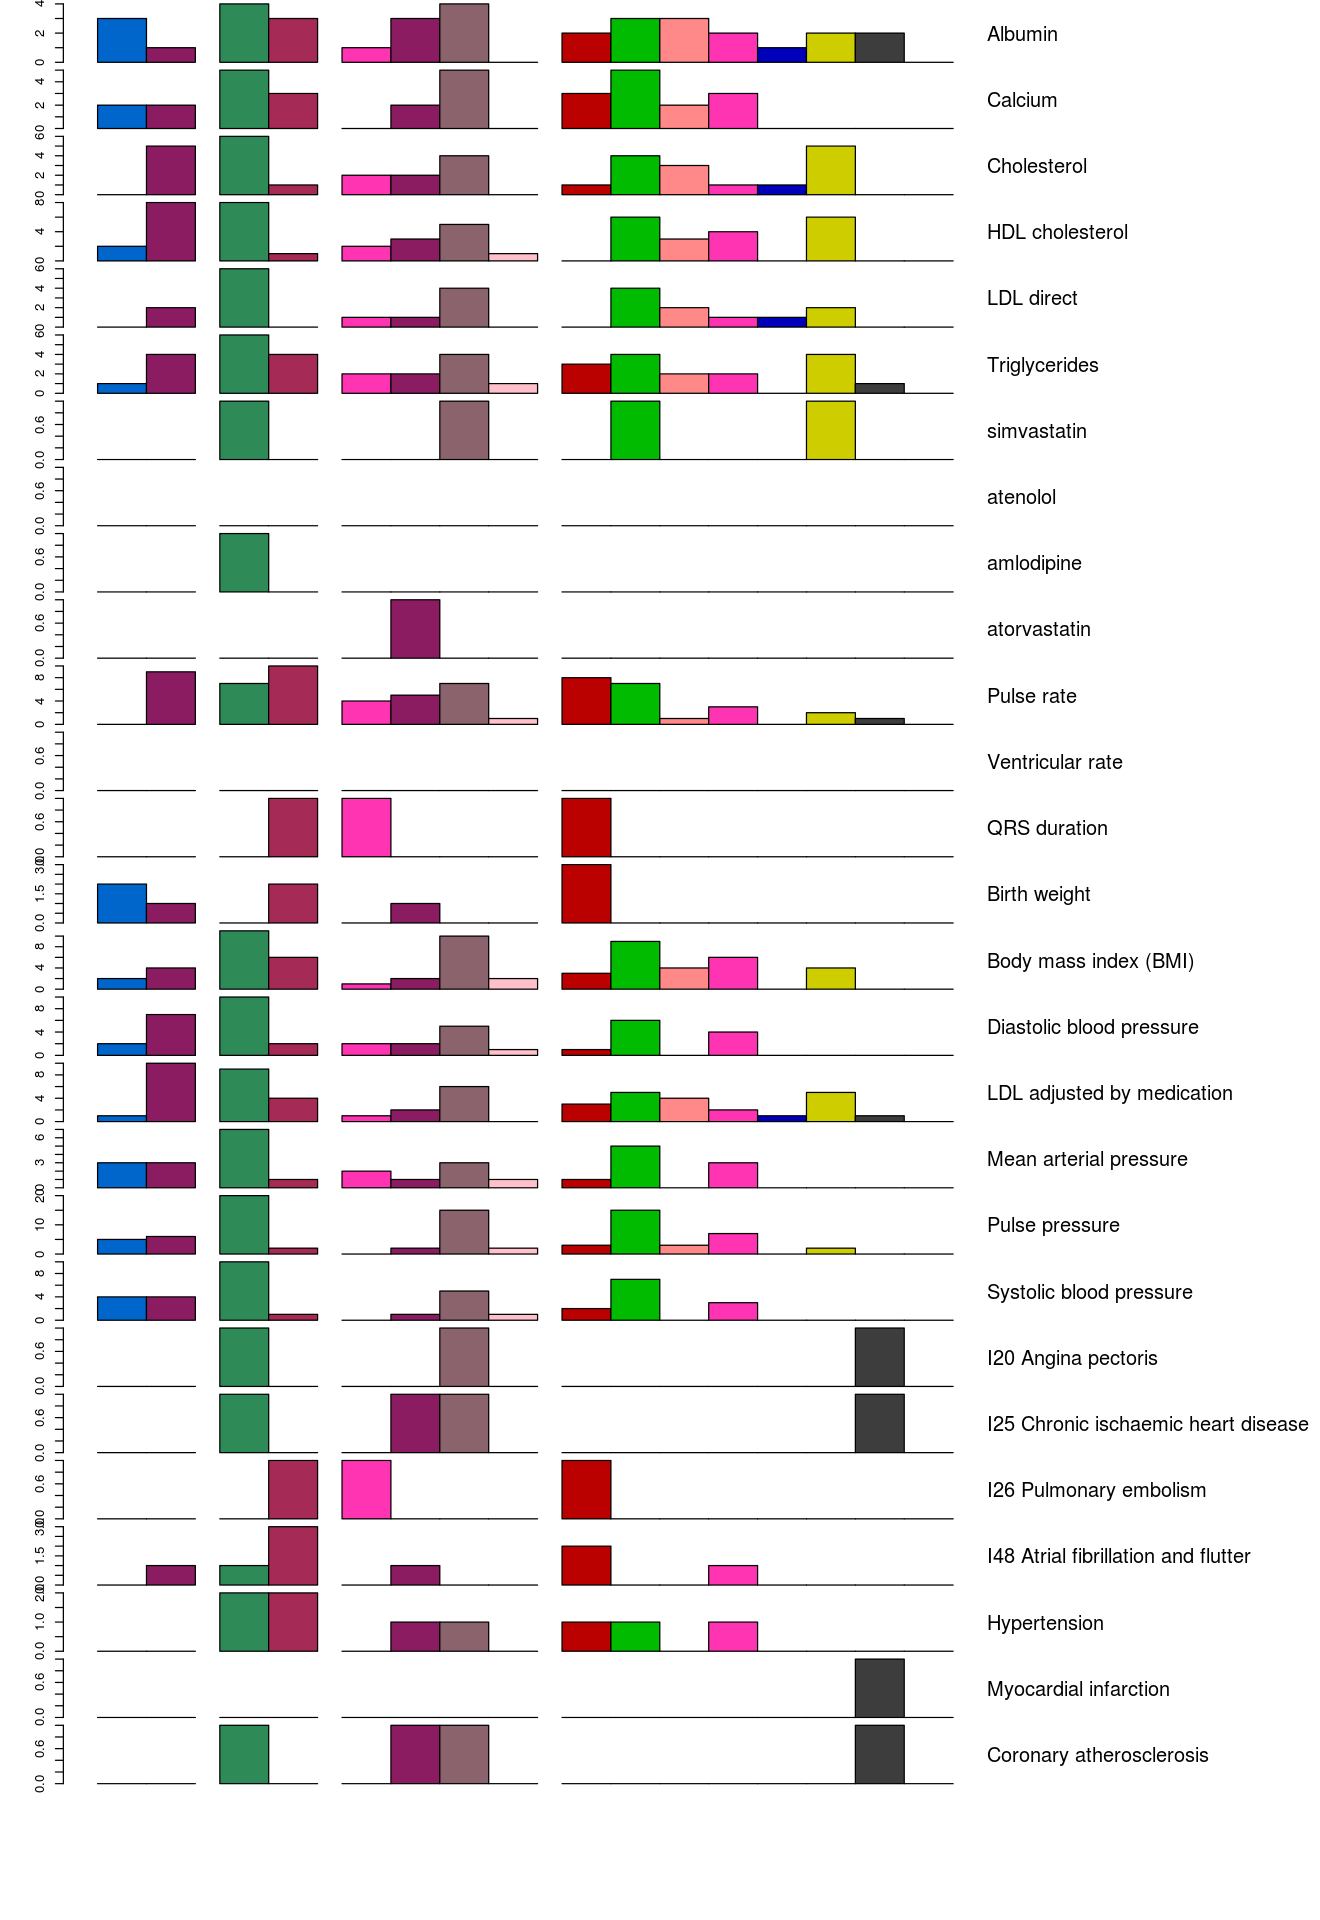

In [58]:
plot_signal2cell = function(trait, tocolor)
{
    par(mar = c(0.1, 4, 0.1, 21))
    
    toplot   = tocolor
    toplot$y = colSums(signal2int[signal2int[,trait] == TRUE, tocolor$body_site])
    
    plot(1,1, type = "n", xlim = c(0, max(toplot$x)), ylim = c(0, max(c(1,toplot$y))), xlab = "", ylab = "", axes = FALSE)
    
    rect(xleft = toplot$x - 1, xright = toplot$x, ybottom = 0, ytop = toplot$y, col = toplot$color)
    axis(2)
    
    mtext(text = manifest[trait, "name"], side = 4, line = 0, at = max(c(1,toplot$y)) / 2, las = 2)
}


figure_4 = function(size_x = 11, size_y = 16,to_png = FALSE)
{
    if(to_png == TRUE ){png(filename = paste(outfolder, "Figure_4.png", sep = "/"), width = size_x, height = size_y, units = "in", res = 300)}
    if(to_png == FALSE){options(repr.plot.width = size_x, repr.plot.height = size_y)}
    
    layout(cbind(c(1:nrow(manifest), nrow(manifest) + c(1,1))))

    colordata$by_stage $x  = colordata$by_stage $order
    colordata$by_organ $x  = colordata$by_organ $order + 0.5 + max(colordata$by_stage $x)
    colordata$by_tissue$x  = colordata$by_tissue$order + 0.5 + max(colordata$by_organ $x)
    colordata$by_cell  $x  = colordata$by_cell  $order + 0.5 + max(colordata$by_tissue$x)
    
    tocolor = rbind(colordata[["by_stage" ]][,c("body_site", "name", "color", "order", "x")],
                    colordata[["by_organ" ]][,c("body_site", "name", "color", "order", "x")],
                    colordata[["by_tissue"]][,c("body_site", "name", "color", "order", "x")],
                    colordata[["by_cell"  ]][,c("body_site", "name", "color", "order", "x")]
                   )
    
    trait = "continuous-DBP-both_sexes-combined_medadj_irnt"
    
    invisible(lapply(manifest$id, function(trait){plot_signal2cell(trait, tocolor)}))

    if(to_png == TRUE ){dev.off()}
}

figure_4(to_png = FALSE)
#figure_4(to_png = TRUE )


In [59]:
manifest$name

[1] "Albumin"                             "Calcium"                            
 [3] "Cholesterol"                         "HDL cholesterol"                    
 [5] "LDL direct"                          "Triglycerides"                      
 [7] "simvastatin"                         "atenolol"                           
 [9] "amlodipine"                          "atorvastatin"                       
[11] "Pulse rate"                          "Ventricular rate"                   
[13] "QRS duration"                        "Birth weight"                       
[15] "Body mass index (BMI)"               "Diastolic blood pressure"           
[17] "LDL adjusted by medication"          "Mean arterial pressure"             
[19] "Pulse pressure"                      "Systolic blood pressure"            
[21] "I20 Angina pectoris"                 "I25 Chronic ischaemic heart disease"
[23] "I26 Pulmonary embolism"              "I48 Atrial fibrillation and flutter"
[25] "Hypertension"                        "Myocardial infarction"              
[27] "Coronary atherosclerosis"

In [60]:
str(signal2int)

'data.frame':	3426 obs. of  65 variables:
 $ id                                            : chr  "1_106956847_107177386.1" "1_107414107_107727697.1" "1_107783043_108102360.1" "1_108663785_108863785.1" ...
 $ chrom                                         : int  1 1 1 1 1 1 0 1 1 1 ...
 $ pos                                           : int  107067308 107596120 107949256 108763785 109820884 110082551 0 111338672 112246541 112289983 ...
 $ som                                           : int  323 184 163 384 169 163 180 163 102 163 ...
 $ locus                                         : chr  "1_106956847_107177386" "1_107414107_107727697" "1_107783043_108102360" "1_108663785_108863785" ...
 $ cluster                                       : int  3 11 11 2 30 11 11 11 18 11 ...
 $ class                                         : chr  "V323" "V184" "V163" "V384" ...
 $ traits                                        : chr  "continuous-DBP-both_sexes-combined_medadj_irnt; continuous-MAP-both_sexes

# Supplemental Tables

## Table S1: GWAS traits

In [61]:
table_s1           = trait2loci
table_s1           = table_s1[order(table_s1$id),]
colnames(table_s1) = c("Trait ID", "Trait name", "Trait type", "Genome-wide significant loci (N)")

fwrite(table_s1, paste(outfolder, "Table_S1.csv", sep = "/"), sep = ",", col.names = TRUE, row.names = FALSE)

In [62]:
message(paste("Trait types", paste(sort(unique(table_s1[,"Trait type"])), collapse = ", "), sep = " = "))

Trait types = biomarkers, categorical, continuous, icd10, phecode



## Table S2: genome-wide significant loci

In [63]:
table_s2           = moloc_df[,c("locus", "chrom", "from", "to", "size", "n_signif", manifest$id)]
colnames(table_s2) = c("Locus ID", "Chromosome", "Start", "End", "Locus size", "Significant traits (N)", manifest$name)

fwrite(table_s2, paste(outfolder, "Table_S2.csv", sep = "/"), sep = ",", col.names = TRUE, row.names = FALSE)

## Table S3: GWAS signals
- provisional: has also data about SOM clusters

In [64]:
table_s3 = as.data.frame(rbindlist(lapply(1:nrow(locus2coloc), function(ii)
{
    x = locus2coloc[ii,]
    x$eqtls   = NULL
    x$eqtls_n = NULL
    x$traits  = paste(sort(manifest[ unlist(strsplit(x$traits, "; ")), "name"]), collapse = "; ")
    
    return(x)
})), stringsAsFactors = FALSE)

table_s3            = table_s3[order(table_s3$locus, table_s3$id), c("id", "locus", "class", "cluster", "traits", "traits_n", "finemapped", "credible_set", "cs_from", "cs_to", "cs_size", "cs_snp", "ref", "alt", "rsid")]
table_s3$finemapped = mapvalues(table_s3$finemapped, from = c(TRUE, FALSE), to = c("Yes", "No"), warn_missing = FALSE)

table_s3[ table_s3$finemapped == "No", c("credible_set"               )] = 0
table_s3[ table_s3$finemapped == "No", c("cs_from", "cs_to", "cs_size")] = NA


colnames(table_s3)  = c("Signal ID", "Locus", "SOM class", "SOM cluster", "Genome-wide significant traits", "Genome-wide significant traits (N)", "Fine-mapped", "SNPs in 99% credible set (N)", "Credible set start", "Credible set end", "Credible set size", "Index SNP", "Reference allele", "Alternative allele", "RS ID")

fwrite(table_s3, paste(outfolder, "Table_S3.csv", sep = "/"), sep = ",", col.names = TRUE, row.names = FALSE)

## Table S4: eQTL metadata

In [65]:
table_s4           = merge(exp_data$metadata[,c("run", "wgs_id", "subject_id", "subject_name", "study", "tissue", "body_site", "phenotype", "udid")], exp_data$covariates[,c("run", "sex", "total_reads_norm", "mitochondrial_reads", grep("cibersort", colnames(exp_data$covariates), value = TRUE))])
table_s4           = table_s4[ table_s4$phenotype == "rna",]
table_s4$study     = mapvalues(x    =              table_s4$study    , from = c("ipscore", "gtex"              ), to = c("iPSCORE" , "GTEx"                ), warn_missing = FALSE)
table_s4$tissue    = mapvalues(x    =              table_s4$tissue   , from = c("arteria", "heart", "ipsc_cvpc"), to = c("Arteria" , "Heart"  , "iPSC-CVPC"), warn_missing = FALSE)
table_s4$sex       = mapvalues(x    = as.character(table_s4$sex)     , from = c("0"      , "1"                 ), to = c("Male"    , "Female"              ), warn_missing = FALSE)
table_s4$body_site = mapvalues(x    =              table_s4$body_site, 
                               from = c("arteria_aorta", "arteria_coronary", "heart_atrium"    , "heart_ventricle", "ipsc_cvpc"), 
                               to   = c("Aorta"        , "Coronary artery" , "Atrial appendage", "Left ventricle" , "iPSC-CVPC"), 
                               warn_missing = FALSE)
table_s4$phenotype = NULL
colnames(table_s4) = c("Assay ID (SRA run ID)", "WGS ID", "Subject ID", "Subject name", "Study", "Tissue", "Body site", "UDID", "Sex", "Reads (normalized)", "Mitochondrial reads (%)", gsub("cibersort.regular.", "", gsub("_", " ", grep("cibersort", colnames(exp_data$covariates), value = TRUE))))

fwrite(table_s4, paste(outfolder, "Table_S4.csv", sep = "/"), sep = ",", col.names = TRUE, row.names = FALSE)

## Table S5: eGenes and eIsoforms

In [66]:
mycols              = c("phenotype", "transcript_id", "gene_id", "gene_name", "gene_type", "type", "id", "chrom", "pos", "ref", "alt", "rsid", "beta", "se", "pval", "tests", "fdr", "qval", "egene")
table_s5a           = qtl_data[["qtl"]][["rna"    ]]
table_s5b           = qtl_data[["qtl"]][["isoform"]]
table_s5a$phenotype = "Gene"
table_s5b$phenotype = "Isoform"
table_s5            = rbind(table_s5a[order(table_s5a$chrom, table_s5a$start, table_s5a$type), mycols], 
                            table_s5b[order(table_s5b$chrom, table_s5b$start, table_s5b$type), mycols])
table_s5$type       = mapvalues(as.character(table_s5$type), from = as.character(0:5), to = c("Primary", paste ("Conditional", 1:5)), warn_missing = FALSE)
table_s5$egene      = mapvalues(             table_s5$egene, from = c(TRUE, FALSE   ), to = c("Yes", "No"                          ), warn_missing = FALSE)
colnames(table_s5)  = c("Phenotype", "Transcript ID", "Gene ID", "Gene name", "Gene type", 
                        "Primary or conditional", "SNP ID", "Chromosome", "Position", "Reference allele", "Alternative allele", "RS ID", 
                        "Beta", "Standard error of beta", "P-value", "Tests (N, EigenMT)", "EigenMT-corrected p-value", "q-value (Benjamini-Hochberg)", "eGene")

fwrite(table_s5, paste(outfolder, "Table_S5.csv", sep = "/"), sep = ",", col.names = TRUE, row.names = FALSE)


## Table S6: interactions between eQTL signals and stage, organ, tissue or cell type

In [67]:
to_names = data.frame(old = c(exp_data$color$by_tissue$body_site, exp_data$color$by_organ$body_site, exp_data$color$by_cell$cell_type),
                      new = c(exp_data$color$by_tissue$tissue   , exp_data$color$by_organ$tissue   , exp_data$color$by_cell$name     )
                     )
to_names = unique(to_names)

In [68]:
tocols               = c("beta", "se", "pval", "qval")
mycols               = c("phenotype", "transcript_id", "gene_id", "type", "id", "interaction", paste(tocols, "int", sep = "_"), paste(tocols, "1", sep = "_"), paste(tocols, "0", sep = "_"), "cell", "specific", "associated")
table_s6a            = qtl_data[["interactions"]][["rna"    ]]
table_s6b            = qtl_data[["interactions"]][["isoform"]]
table_s6a$phenotype  = "Gene"
table_s6b$phenotype  = "Isoform"
table_s6             = rbind(table_s6a[order(table_s6a$transcript_id, table_s6a$type, table_s6a$interaction), mycols], 
                             table_s6b[order(table_s6b$transcript_id, table_s6b$type, table_s6b$interaction), mycols])
 
table_s6$type        = mapvalues(as.character(table_s6$type)      , from = as.character(0:5), to = c("Primary", paste ("Conditional", 1:5)), warn_missing = FALSE)
table_s6$cell        = mapvalues(             table_s6$cell       , from = c(TRUE, FALSE   ), to = c("Yes", "No"                          ), warn_missing = FALSE)
table_s6$specific    = mapvalues(             table_s6$specific   , from = c(TRUE, FALSE   ), to = c("Yes", "No"                          ), warn_missing = FALSE)
table_s6$associated  = mapvalues(             table_s6$associated , from = c(TRUE, FALSE   ), to = c("Yes", "No"                          ), warn_missing = FALSE)
table_s6$interaction = mapvalues(             table_s6$interaction, from = to_names$old     , to = to_names$new                            , warn_missing = FALSE)

tocol_names         = c("Beta", "Standard error of beta", "P-value")
colnames(table_s6)  = c("Phenotype", "Transcript ID", "Gene ID", "Primary or conditional", "SNP ID", "Interaction",
                        paste(tocol_names, "(interaction)"), "FDR interaction (Bonferroni)",
                        paste(tocol_names, "(stage, organ, tissue, or top quartile)"), "q-value (stage, organ, tissue, or top quartile, Benjamini-Hochberg)",
                        paste(tocol_names, "(rest or bottom quartile)"), "q-value (rest or bottom quartile, Benjamini-Hochberg)",
                        "Is the interaction present", "Is specific", "Is associated")

fwrite(table_s6, paste(outfolder, "Table_S6.csv", sep = "/"), sep = ",", col.names = TRUE, row.names = FALSE)


## Table S7: Colocalization between each eIsoform and its associated eGene

In [69]:
table_s7            = coloc_iso[coloc_iso$transcript_id2 %in% egenes_id, c("transcript_id1", "transcript_id2", "type1", "type2", paste0("PP.H", 0:4, ".abf"), "id", "pp_snp")]
table_s7$type1      = mapvalues(as.character(table_s7$type1)      , from = as.character(0:5), to = c("Primary", paste ("Conditional", 1:5)), warn_missing = FALSE)
table_s7$type2      = mapvalues(as.character(table_s7$type2)      , from = as.character(0:5), to = c("Primary", paste ("Conditional", 1:5)), warn_missing = FALSE)
colnames(table_s7)  = c("Transcript ID", "Gene ID", "Primary or conditional (eIsoform)", "Primary or conditional (eGene)", 
                        paste("PPA, hypothesis", 0:4), "SNP ID", "PPA SNP")

fwrite(table_s7, paste(outfolder, "Table_S7.csv", sep = "/"), sep = ",", col.names = TRUE, row.names = FALSE)


# Data to figshare (associated with supplemental tables)

## Table S4 (expanded): all PEER factors and genotype PCs

In [70]:
eqtl_covariates = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/3.1.covariates/covariates.txt", sep = "\t", header = TRUE, data.table = FALSE))

In [71]:
table_s4f           = merge(exp_data$metadata[,c("run", "wgs_id", "subject_id", "subject_name", "study", "tissue", "body_site", "phenotype", "udid")], exp_data$covariates[,c("run", "sex", "total_reads_norm", "mitochondrial_reads", grep("cibersort", colnames(exp_data$covariates), value = TRUE))])
table_s4f           = table_s4f[ table_s4f$phenotype == "rna",]
table_s4f           = merge(table_s4f, eqtl_covariates[,c(paste0("peer", 1:300), paste0("pc", 1:20))], by.x = "run", by.y = "row.names")
table_s4f$sex       = mapvalues(x    = as.character(table_s4f$sex), from = c("0", "1"), to = c("male", "female"), warn_missing = FALSE)
table_s4f$phenotype = NULL
colnames(table_s4f) = gsub("cibersort.regular.", "", colnames(table_s4f))

fwrite(table_s4f, paste(outfolder, "figshare", "table_s4f.txt", sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)

## Table S5 (expanded): list including all summary stastistics (separated gene/isoform)

In [72]:
colnames(eqtl_covariates)

[1] "sex"                                          
  [2] "age"                                          
  [3] "height"                                       
  [4] "weight"                                       
  [5] "bmi"                                          
  [6] "total_reads"                                  
  [7] "total_reads_norm"                             
  [8] "uniquely_mapped_reads_to_canonical_chromsomes"
  [9] "mitochondrial_reads"                          
 [10] "peer1"                                        
 [11] "peer2"                                        
 [12] "peer3"                                        
 [13] "peer4"                                        
 [14] "peer5"                                        
 [15] "peer6"                                        
 [16] "peer7"                                        
 [17] "peer8"                                        
 [18] "peer9"                                        
 [19] "peer10"                                       
 [20] "peer11"                                       
 [21] "peer12"                                       
 [22] "peer13"                                       
 [23] "peer14"                                       
 [24] "peer15"                                       
 [25] "peer16"                                       
 [26] "peer17"                                       
 [27] "peer18"                                       
 [28] "peer19"                                       
 [29] "peer20"                                       
 [30] "peer21"                                       
 [31] "peer22"                                       
 [32] "peer23"                                       
 [33] "peer24"                                       
 [34] "peer25"                                       
 [35] "peer26"                                       
 [36] "peer27"                                       
 [37] "peer28"                                       
 [38] "peer29"                                       
 [39] "peer30"                                       
 [40] "peer31"                                       
 [41] "peer32"                                       
 [42] "peer33"                                       
 [43] "peer34"                                       
 [44] "peer35"                                       
 [45] "peer36"                                       
 [46] "peer37"                                       
 [47] "peer38"                                       
 [48] "peer39"                                       
 [49] "peer40"                                       
 [50] "peer41"                                       
 [51] "peer42"                                       
 [52] "peer43"                                       
 [53] "peer44"                                       
 [54] "peer45"                                       
 [55] "peer46"                                       
 [56] "peer47"                                       
 [57] "peer48"                                       
 [58] "peer49"                                       
 [59] "peer50"                                       
 [60] "peer51"                                       
 [61] "peer52"                                       
 [62] "peer53"                                       
 [63] "peer54"                                       
 [64] "peer55"                                       
 [65] "peer56"                                       
 [66] "peer57"                                       
 [67] "peer58"                                       
 [68] "peer59"                                       
 [69] "peer60"                                       
 [70] "peer61"                                       
 [71] "peer62"                                       
 [72] "peer63"                                       
 [73] "peer64"                                       
 [74] "peer65"                                       
 [75] 

In [73]:
1

[1] 1